# Setup

- The Liesel documentation can be found here: https://docs.liesel-project.org/en/latest/
- Track the release of new versions and report bugs here: https://github.com/liesel-devs/liesel
- Please feel invited to ask questions here: https://github.com/liesel-devs/liesel/discussions

In [2]:
# This cell installs the necessary packages.
# Uncomment the lines below to install the packages when running
# the notebook on Google Colab.

# %%capture
# !apt install libgraphviz-dev # necessary here for successful pygraphviz installation
# %pip install pygraphviz # install pygraphviz (for plotting model graphs nicely)
# %pip install rpy2 # install rpy2 for interfacing R and Python
# %pip install liesel # install liesel
# %pip install plotnine # install plotnine for ggplot2-like plotting in Python


In [3]:
# This cell installs R, mgcv and BayesX for us
# Uncomment the lines below to install the packages when running
# the notebook on Google Colab.

# careful, the installation of BayesX takes a long time!

# the command '%%capture' prevents ouput from being continuously printed
# this is nice here, because the output is very long

# %%capture
# !apt-get install -y r-base
# !Rscript -e "install.packages('mgcv', repos='http://cran.rstudio.com/')"
# !Rscript -e "install.packages('BayesX', repos='http://cran.rstudio.com/')"

In [4]:
%load_ext rpy2.ipython

In [5]:
import pandas as pd # for data frames
import numpy as np # for numerical operations
import jax.numpy as jnp # for jit-compilable numerical operations
import tensorflow_probability.substrates.jax.distributions as tfd # for probability distributions


import liesel.model as lsl # Liesel's model-building module
import liesel.goose as gs # Liesel's MCMC module
from liesel.distributions import MultivariateNormalDegenerate as MVND # for the rank-deficient multivariate normal distribution

import plotnine as p9 # for ggplot2-like plotting

In [6]:
from jax.scipy.special import logit

In [7]:
# for interfacing R and Python
from rpy2 import robjects

# robjects.pandas2ri.activate() 

In [8]:
%%R
# the %%R magic command allows us to run R code in a cell
library(mgcv)

Lade nötiges Paket: nlme
This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.


## Data Import

In [9]:
%%R -o forest
# the -o flag allows us to pass variables from R to Python
# in this case, we pass the data frame to Python
# multiple variables can be passed by separating them with commas, without spaces.

forest <- read.table("https://raw.githubusercontent.com/liesel-devs/florence-2025/refs/heads/main/data/foresthealth.dat", header=TRUE)

In [10]:
# pass the zambia data frame to Python
# we explicitly convert the data frame to a pandas data frame
forest = robjects.pandas2ri.rpy2py(robjects.globalenv['forest'])

# Model 1: Logit

## Model Setup

### Nonlinear effect for age

In [11]:
%%R -o basis_age_r,pen_age_r
# set up basis matrix and penalty matrix in magcv

s_age <- mgcv::smoothCon(
    s(age, bs="ps", m=c(3,2), k=10),
    data = forest,
    knots = NULL,
    absorb.cons = TRUE
)

# basis_age_r <- s_age[[1]]$X
# pen_age_r <- s_age[[1]]$S[[1]]

# optional diagonalization of the penalty matrix
s_age <- s_age[[1]] |> mgcv::smooth2random(vnames = "", type = 2)

basis_age_r <- cbind(s_age$rand$Xr, s_age$Xf)
pen_age_r <- diag(s_age$pen.ind)

In [12]:
# get R objects into python
basis_age_r = robjects.globalenv['basis_age_r']
pen_age_r = robjects.globalenv['pen_age_r']

In [13]:
# set up structured additive term in liesel
basis_age = lsl.Var.new_obs(basis_age_r, name="basis_age")

mvnd = MVND.from_penalty(loc=0.0, var=1.0, pen=pen_age_r)

# set up tau2 prior and variable
# tau2_age_prior = lsl.Dist(tfd.InverseGamma, concentration=0.01, scale=0.01)
# tau2_age = lsl.Var.new_param(10.0, tau2_age_prior, name="tau2_age")
# var_param_age = tau2_age

# A diffuse prior with nonzero density at zero
# The scale can be set according to the principles of a scale-dependent prior
# See Klein & Kneib (2016) for details
tau_age_prior = lsl.Dist(tfd.Weibull, concentration=0.5, scale=20.0)
tau_age = lsl.Var.new_param(10.0, tau_age_prior, name="tau_age")
tau2_age = lsl.Var.new_calc(jnp.square, tau_age, name="tau2_age")
var_param_age = tau_age

# set up coefficient prior
coef_age_prior = lsl.Dist(
    MVND.from_penalty,
    loc=0.0,
    var=tau2_age,
    pen=pen_age_r,
    rank=mvnd.rank,
    log_pdet=mvnd.log_pdet
)

# set up coefficient variable
coef_age = lsl.Var.new_param(
    value=jnp.zeros(basis_age_r.shape[1]),
    distribution=coef_age_prior,
    name="coef_age"
)

# set up effect variable
s_age = lsl.Var.new_calc(jnp.dot, basis_age, coef_age, name="s_age")

### Nonlinear effect for canopy

In [14]:
%%R -o basis_canopy_r,pen_canopy_r
# set up basis matrix and penalty matrix in magcv

s_canopy <- mgcv::smoothCon(
    s(canopy, bs="ps", m=c(3,2), k=10),
    data = forest,
    knots = NULL,
    absorb.cons = TRUE
)

# basis_canopy_r <- s_canopy[[1]]$X
# pen_canopy_r <- s_canopy[[1]]$S[[1]]

# optional diagonalization of the penalty matrix
s_canopy <- s_canopy[[1]] |> mgcv::smooth2random(vnames = "", type = 2)

basis_canopy_r <- cbind(s_canopy$rand$Xr, s_canopy$Xf)
pen_canopy_r <- diag(s_canopy$pen.ind)

In [15]:
# get R objects into python
basis_canopy_r = robjects.globalenv['basis_canopy_r']
pen_canopy_r = robjects.globalenv['pen_canopy_r']

In [16]:
# set up structured additive term in liesel
basis_canopy = lsl.Var.new_obs(basis_canopy_r, name="basis_canopy")

mvnd = MVND.from_penalty(loc=0.0, var=1.0, pen=pen_canopy_r)

# set up tau2 prior and variable
# tau2_canopy_prior = lsl.Dist(tfd.InverseGamma, concentration=0.01, scale=0.01)
# tau2_canopy = lsl.Var.new_param(10.0, tau2_canopy_prior, name="tau2_canopy")
# var_param_canopy = tau2_canopy

# A diffuse prior with nonzero density at zero
# The scale can be set according to the principles of a scale-dependent prior
# See Klein & Kneib (2016) for details
tau_canopy_prior = lsl.Dist(tfd.Weibull, concentration=0.5, scale=20.0)
tau_canopy = lsl.Var.new_param(10.0, tau_canopy_prior, name="tau_canopy")
tau2_canopy = lsl.Var.new_calc(jnp.square, tau_canopy, name="tau2_canopy")
var_param_canopy = tau_canopy

# set up coefficient prior
coef_canopy_prior = lsl.Dist(
    MVND.from_penalty,
    loc=0.0,
    var=tau2_canopy,
    pen=pen_canopy_r,
    rank=mvnd.rank,
    log_pdet=mvnd.log_pdet
)

# set up coefficient variable
coef_canopy = lsl.Var.new_param(
    value=jnp.zeros(basis_canopy_r.shape[1]),
    distribution=coef_canopy_prior,
    name="coef_canopy"
)

# set up effect variable
s_canopy = lsl.Var.new_calc(jnp.dot, basis_canopy, coef_canopy, name="s_canopy")

### Observation Model

In [17]:
intercept = lsl.Var.new_param(
    logit(forest["def"].mean()), # crude starting value
    name="intercept"
)

logits = lsl.Var.new_calc(lambda *args: sum(args), intercept, s_age, s_canopy, name="logits")

def_dist = lsl.Dist(tfd.Bernoulli, logits=logits)
def_ = lsl.Var.new_obs(forest["def"].values, distribution=def_dist, name="def")

liesel.model.model - INFO - Converted dtype of Value(name="").value
liesel.model.model - INFO - Converted dtype of Value(name="basis_canopy_value").value
liesel.model.model - INFO - Converted dtype of Value(name="").value
liesel.model.model - INFO - Converted dtype of Value(name="basis_age_value").value
liesel.model.nodes - INFO - Unnamed nodes were temporarily named for plottingThe automatically assigned names are: ['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10', 'n11']. The names are reset after plotting.


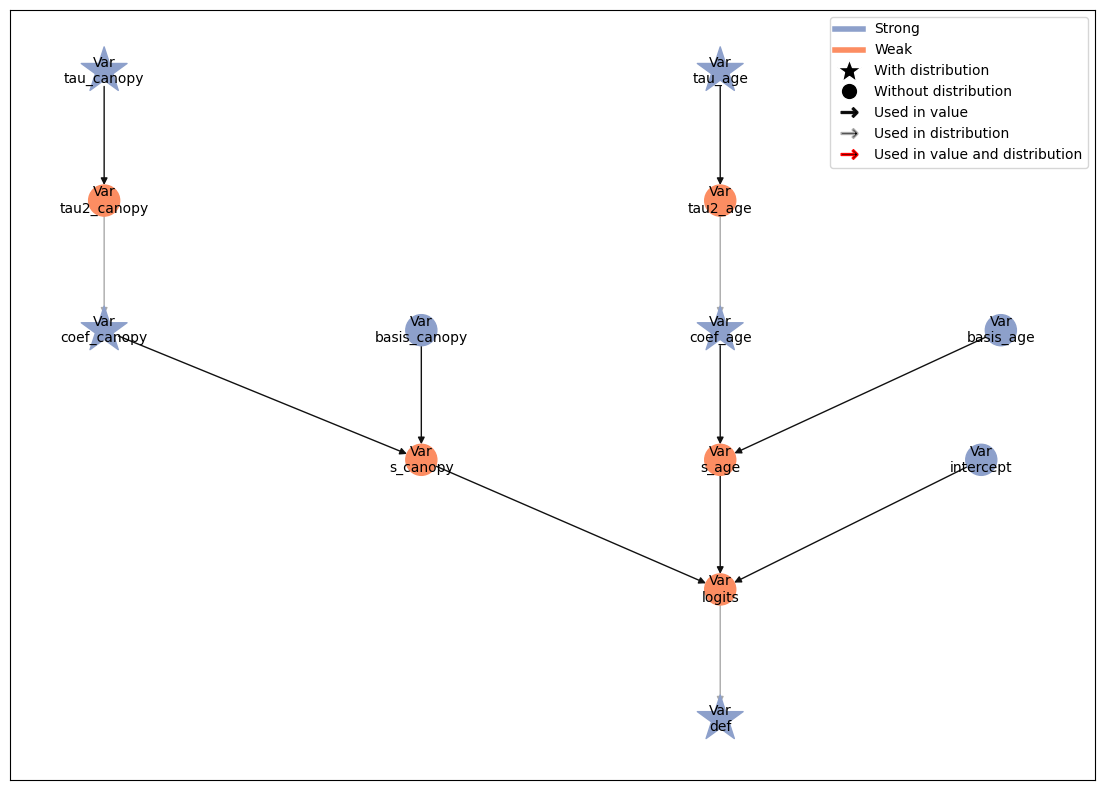

In [18]:
def_.plot_vars()

In [19]:
model1 = lsl.Model([def_])
interface = gs.LieselInterface(model1)

In [20]:
import optax

# crude, but robust optimization
preopt = gs.optim_flat(
    model_train=model1,
    params=[intercept.name, coef_age.name, coef_canopy.name],
    stopper=gs.Stopper(max_iter=10_000, patience=10, atol=1e-3),
    optimizer=optax.adam(learning_rate=0.01)
)

Training loss: 968.660, Validation loss: 968.660:  60%|█████▉    | 5973/10000 [00:28<00:18, 220.56it/s]

In [21]:
eb = gs.EngineBuilder(seed=42, num_chains=4)

eb.set_model(interface)
eb.set_initial_values(preopt.model_state)

eb.add_kernel(gs.NUTSKernel([intercept.name]))

eb.add_kernel(gs.IWLSKernel([coef_age.name]))
eb.add_kernel(gs.IWLSKernel([coef_canopy.name]))

eb.add_kernel(gs.NUTSKernel([var_param_age.name]))
eb.add_kernel(gs.NUTSKernel([var_param_canopy.name]))

eb.positions_included = [s_age.name, s_canopy.name]

eb.set_duration(warmup_duration=2000, posterior_duration=4000, thinning_posterior=10)

In [22]:
engine = eb.build()

liesel.goose.builder - WARNING - No jitter functions provided. The initial values won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done


In [23]:
engine.sample_all_epochs()

liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 75 transitions, 25 jitted together
100%|██████████████████████████████████████████| 3/3 [00:07<00:00,  2.39s/chunk]0:40<00:18, 220.56it/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 1, 4, 3, 1 / 75 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_03: 2, 5, 7, 10 / 75 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_04: 6, 10, 7, 5 / 75 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 631.86chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 1, 1, 1, 1 / 25 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_03: 0, 0, 2, 4 / 25 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_04: 3, 5, 3, 3 / 25 transitions
liesel.goose.engine - I

In [24]:
results1 = engine.get_results()
samples1 = results1.get_posterior_samples()
summary1 = gs.Summary(results1, deselected=eb.positions_included)

In [25]:
summary1

Parameter summary:

                      kernel      mean        sd    q_0.05     q_0.5  \
parameter   index                                                      
coef_age    (0,)   kernel_01 -1.245703  1.470240 -3.813780 -1.090024   
            (1,)   kernel_01  2.941896  1.933828  0.149849  2.738033   
            (2,)   kernel_01  0.545218  1.847182 -2.210525  0.425025   
            (3,)   kernel_01 -0.478280  1.847288 -3.442341 -0.561739   
            (4,)   kernel_01 -0.703398  1.798368 -3.905793 -0.502041   
            (5,)   kernel_01  2.967972  1.624861  0.681351  2.782028   
            (6,)   kernel_01  0.641611  1.056802 -0.829226  0.513376   
            (7,)   kernel_01 -1.549112  0.516811 -2.474261 -1.486243   
            (8,)   kernel_01  9.256639  8.899760 -3.236571  8.140383   
coef_canopy (0,)   kernel_02  0.049415  0.363044 -0.468791  0.034941   
            (1,)   kernel_02 -0.048617  0.368577 -0.650212 -0.025522   
            (2,)   kernel_02 -0.172854  0.325593 -0.706590 -0.138805   
            (3,)   kernel_02  0.136437  0.336325 -0.336093  0.117678   
            (4,)   kernel_02  0.074460  0.309305 -0.357483  0.044156   
            (5,)   kernel_02  0.171245  0.284909 -0.264881  0.175307   
            (6,)   kernel_02  0.304909  0.237240 -0.006352  0.274577   
            (7,)   kernel_02  0.034682  0.123292 -0.140153  0.026043   
            (8,)   kernel_02 -2.253047  3.344652 -6.990206 -2.620850   
intercept   ()     kernel_00 -0.792956  0.083971 -0.936089 -0.789393   
tau_age     ()     kernel_03  2.425892  1.216485  0.914196  2.228466   
tau_canopy  ()     kernel_04  0.336214  0.227418  0.107953  0.279636   

                      q_0.95  sample_size     ess_bulk     ess_tail      rhat  
parameter   index                                                              
coef_age    (0,)    0.888305         1600   724.360321  1244.973418  1.003197  
            (1,)    6.437457         1600   567.122789   917.622219  1.006271  
            (2,)    3.632169         1600   906.229514  1118.003671  1.008271  
            (3,)    2.532598         1600  1089.567290  1024.812595  1.004614  
            (4,)    1.818642         1600   885.415027  1128.000765  1.008823  
            (5,)    5.827541         1600   633.226573   875.401001  1.004914  
            (6,)    2.512962         1600   761.636797  1169.038259  1.007615  
            (7,)   -0.800835         1600   453.490745   513.319783  1.004150  
            (8,)   25.303033         1600   722.283262  1106.468035  1.007035  
coef_canopy (0,)    0.639045         1600   865.311765   833.397488  1.000442  
            (1,)    0.481813         1600  1053.202229  1112.285958  1.006588  
            (2,)    0.278005         1600   976.133356   832.237287  1.007506  
            (3,)    0.669511         1600  1072.878368  1055.478790  1.004509  
            (4,)    0.621338         1600  1064.646970   786.446145  1.003714  
            (5,)    0.580515         1600   978.655019   737.761721  1.004226  
            (6,)    0.737329         1600   658.929205   622.340049  1.005119  
            (7,)    0.241097         1600   679.203288   744.626583  1.005617  
            (8,)    3.723711         1600   506.058021   789.316348  1.009941  
intercept   ()     -0.663732         1600   532.350179  1007.509038  1.007798  
tau_age     ()      4.710268         1600   342.933181   422.553025  1.005361  
tau_canopy  ()      0.722533         1600   329.841541   390.428530  1.015730  

Error summary:

                                                    count  relative
kernel    error_code error_msg            phase                    
kernel_00 1          divergent transition warmup       58   0.00725
                                          posterior     0       0.0
kernel_03 1          divergent transition warmup      412    0.0515
                                          posterior   184     0.115
kernel_04 1          divergent transition warmup      423 

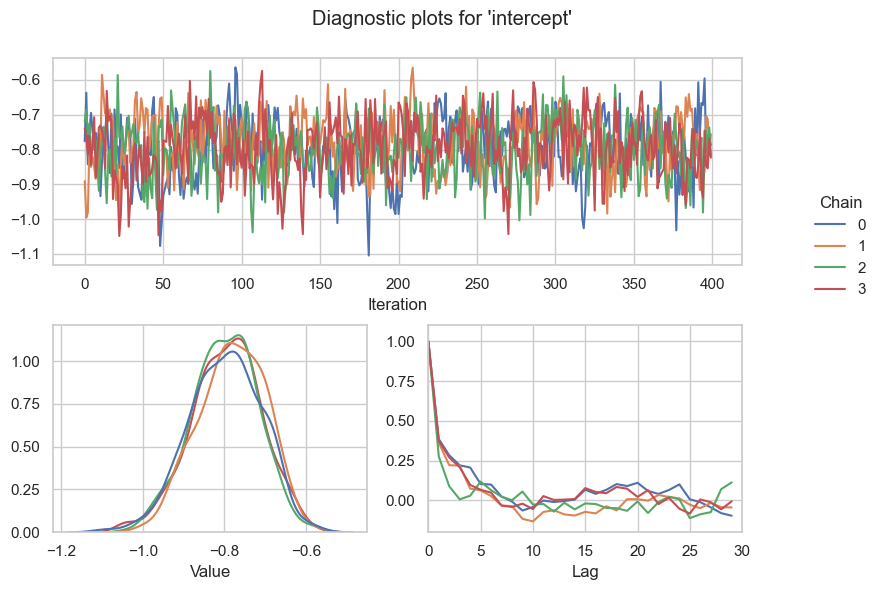

In [26]:
gs.plot_param(results1, "intercept")

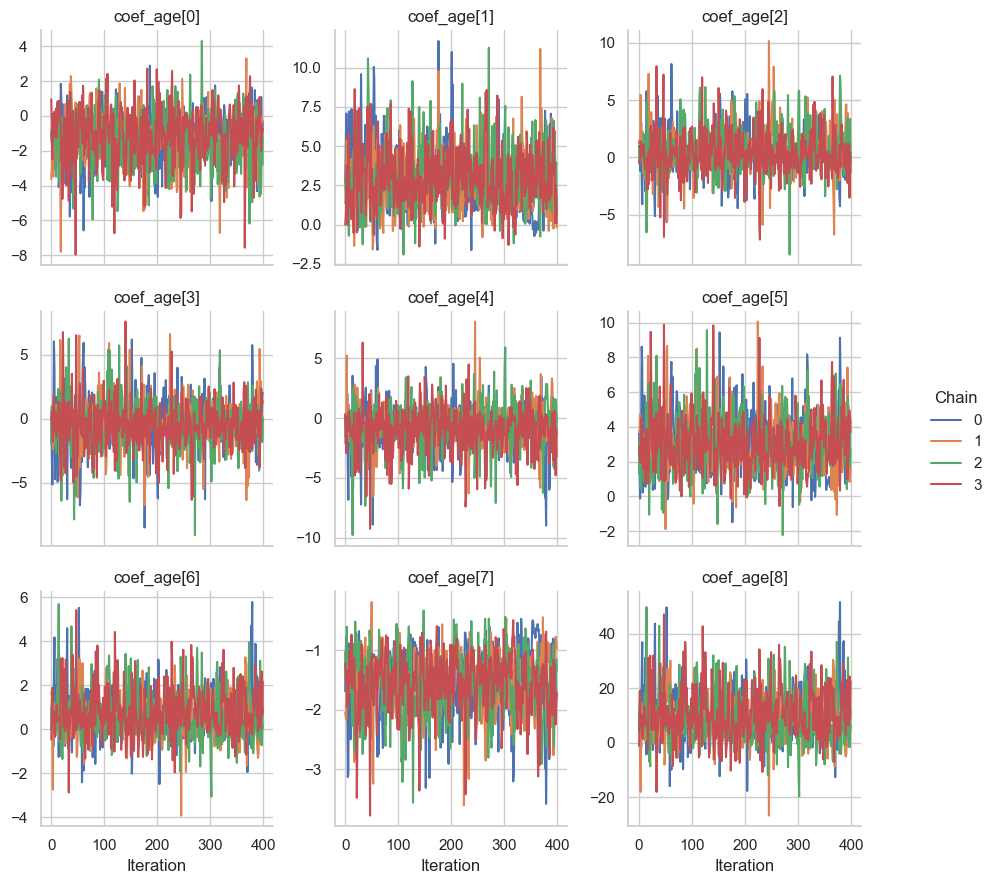

In [27]:
gs.plot_trace(results1, "coef_age")

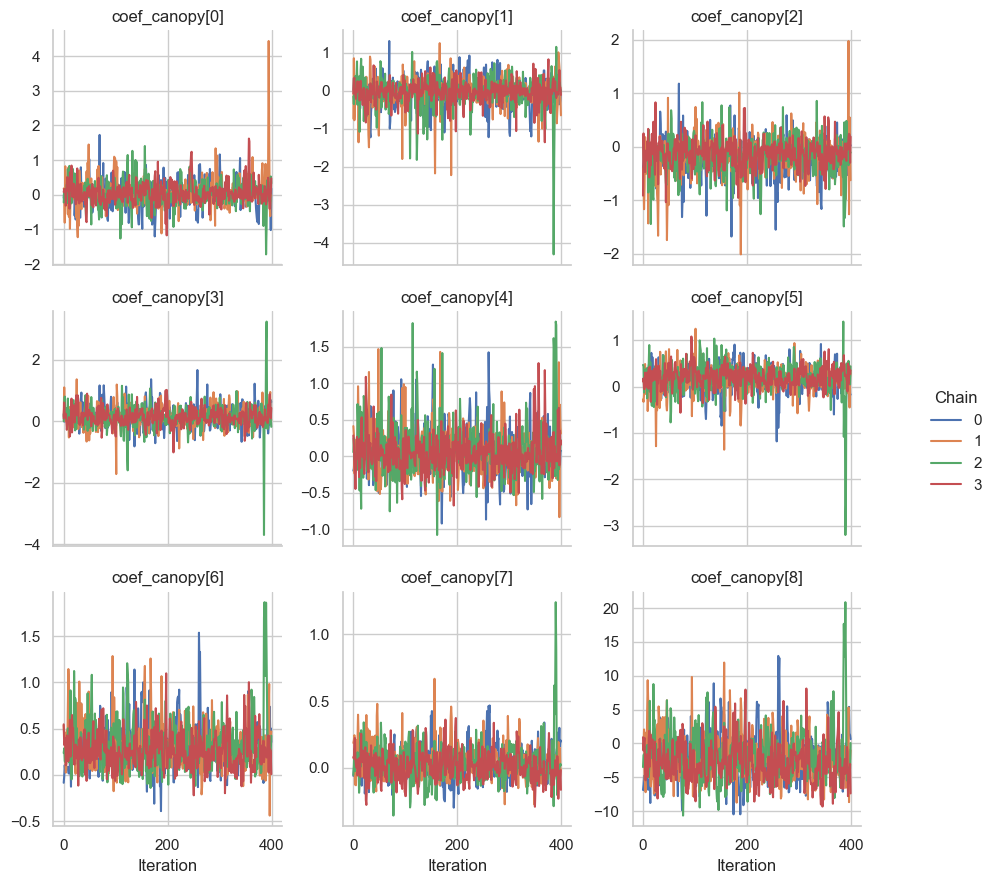

In [28]:
gs.plot_trace(results1, "coef_canopy")

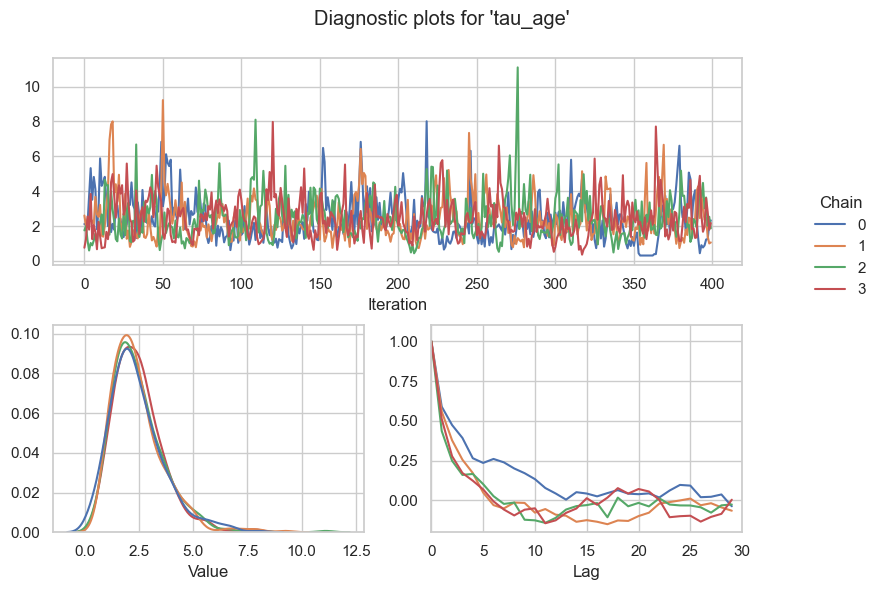

In [29]:
try:
    gs.plot_param(results1, "tau2_age")
except KeyError:
    gs.plot_param(results1, "tau_age")

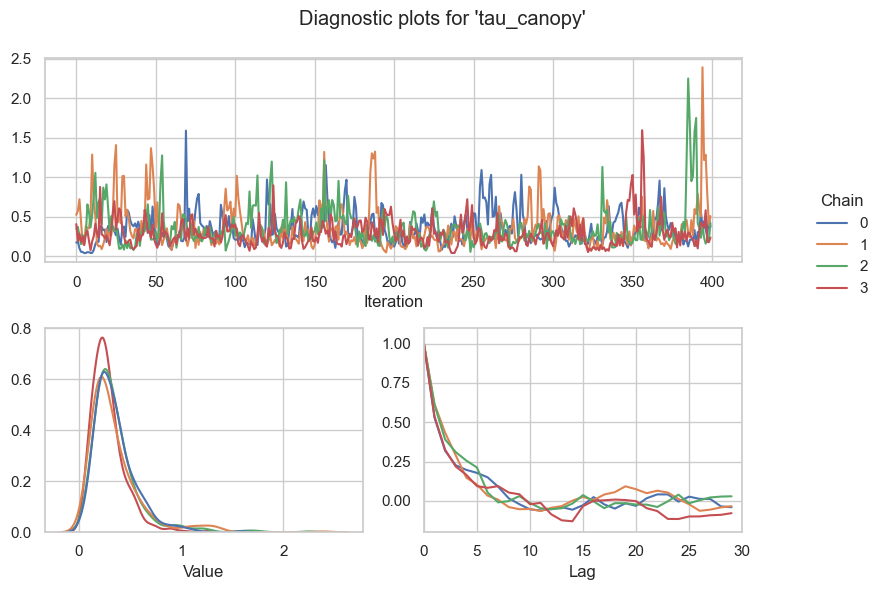

In [30]:
try:
    gs.plot_param(results1, "tau2_canopy")
except KeyError:
    gs.plot_param(results1, "tau_canopy")

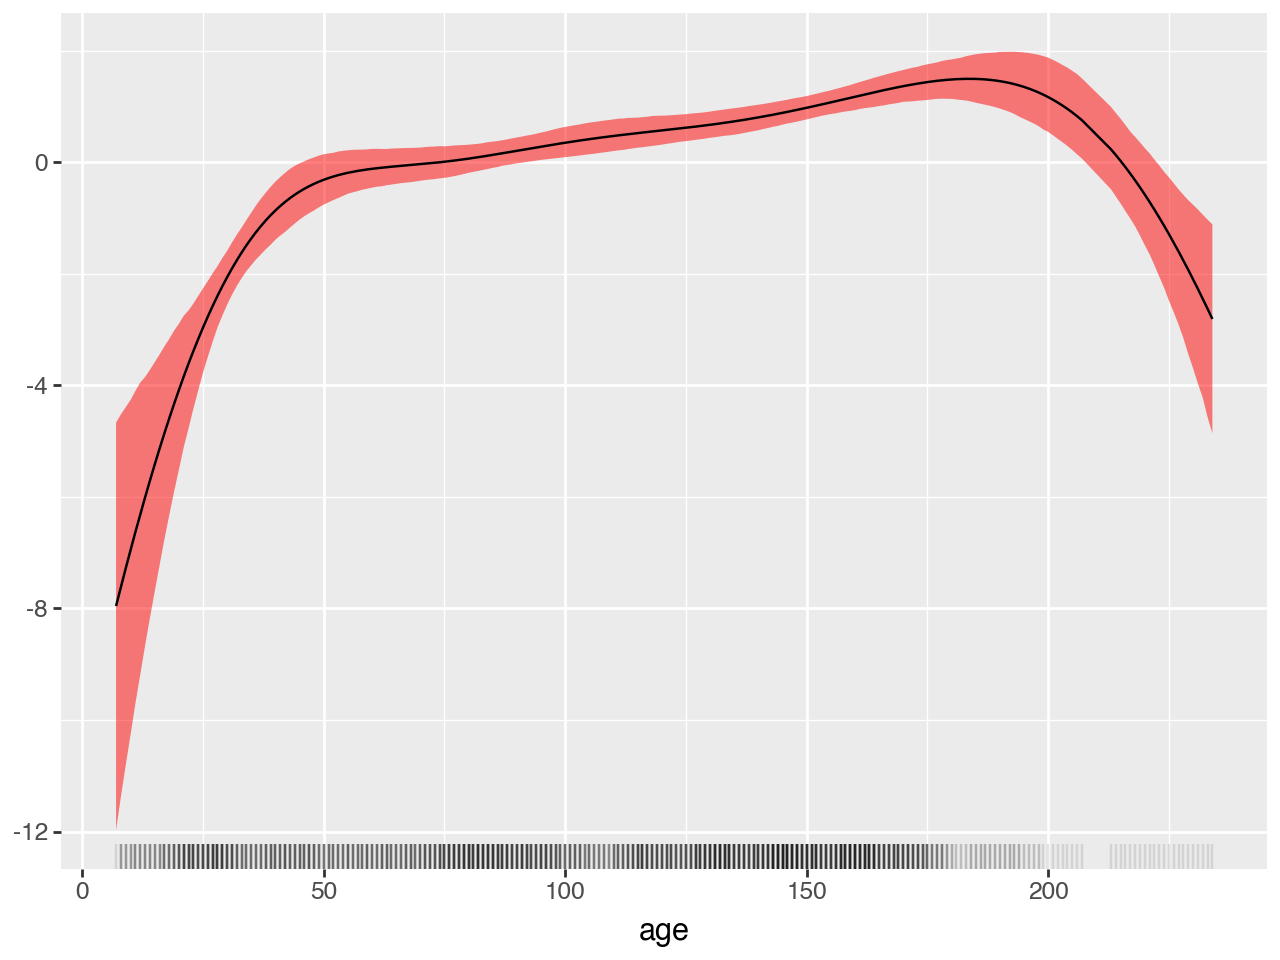

In [31]:
age_samples = np.asarray(samples1[s_age.name]) # convert to numpy array for plotting

s_age_mean = np.mean(samples1[s_age.name], axis=(0, 1))
s_age_lo = np.quantile(samples1[s_age.name], 0.025, axis=(0, 1))
s_age_hi = np.quantile(samples1[s_age.name], 0.975, axis=(0, 1))

(
    p9.ggplot()
    + p9.geom_ribbon(p9.aes(x=forest["age"], ymin=s_age_lo, ymax=s_age_hi), alpha=0.5, fill = "red")
    + p9.geom_line(p9.aes(x=forest["age"], y=s_age_mean))
    + p9.geom_rug(p9.aes(x=forest["age"]), alpha = 0.1)
)

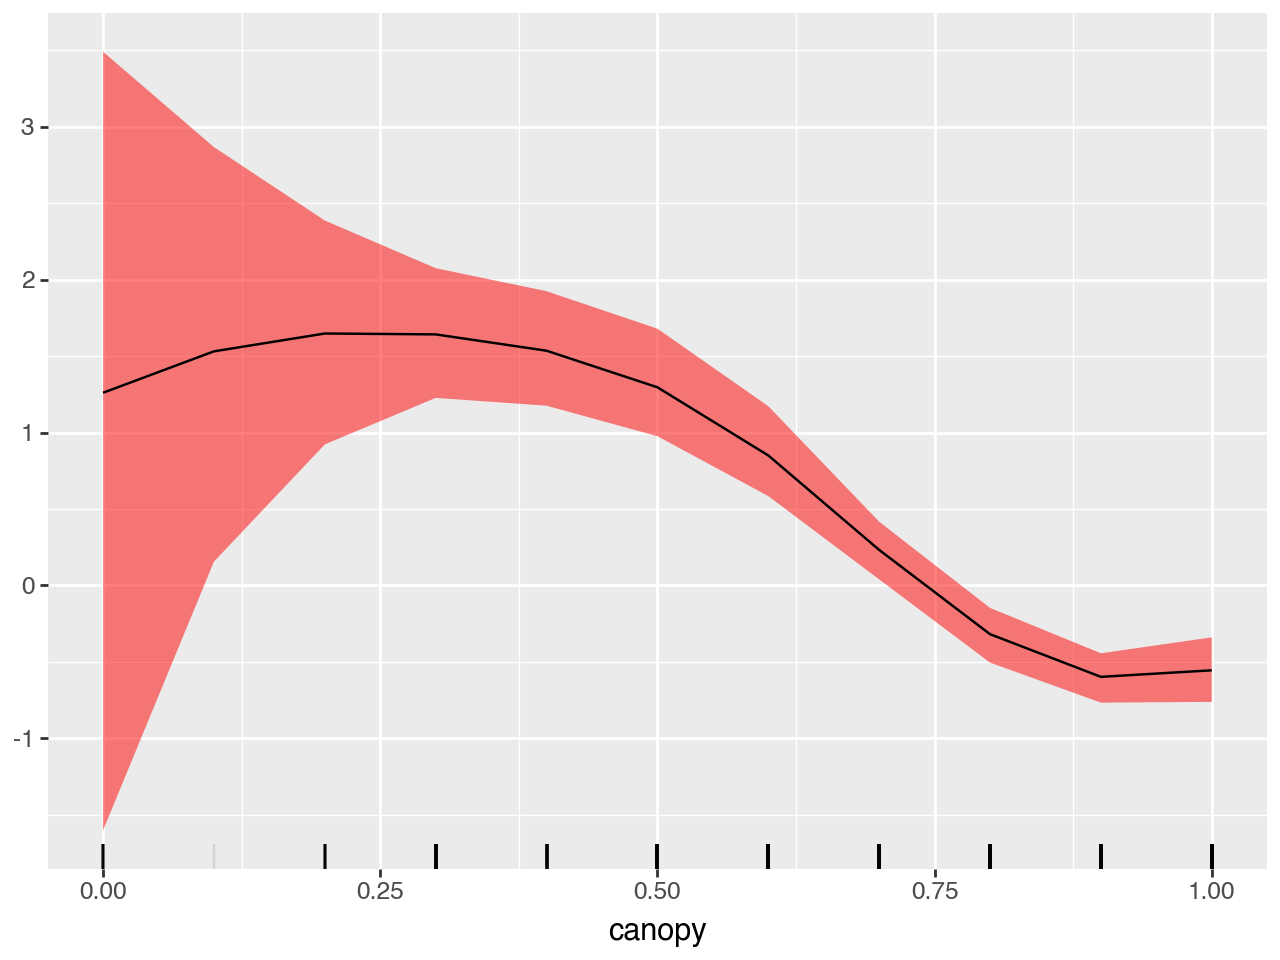

In [32]:
bmi_samples = np.asarray(samples1[s_canopy.name]) # convert to numpy for plotting

s_canopy_mean = np.mean(samples1[s_canopy.name], axis=(0, 1))
s_canopy_lo = np.quantile(samples1[s_canopy.name], 0.025, axis=(0, 1))
s_canopy_hi = np.quantile(samples1[s_canopy.name], 0.975, axis=(0, 1))

(
    p9.ggplot()
    + p9.geom_ribbon(p9.aes(x=forest["canopy"], ymin=s_canopy_lo, ymax=s_canopy_hi), alpha=0.5, fill = "red")
    + p9.geom_line(p9.aes(x=forest["canopy"], y=s_canopy_mean))
    + p9.geom_rug(p9.aes(x=forest["canopy"]), alpha = 0.1)
)

# Model 2: Probit

In [33]:
_ = model1.pop_nodes_and_vars()

In [34]:
intercept = lsl.Var.new_param(
    tfd.Normal(loc=0.0, scale=1.0).quantile((forest["def"].mean())), # crude starting value
    name="intercept"
)

probits = lsl.Var.new_calc(lambda *args: sum(args), intercept, s_age, s_canopy, name="probits")

def_dist = lsl.Dist(tfd.ProbitBernoulli, probits=logits)
def_ = lsl.Var.new_obs(forest["def"].values, distribution=def_dist, name="def")

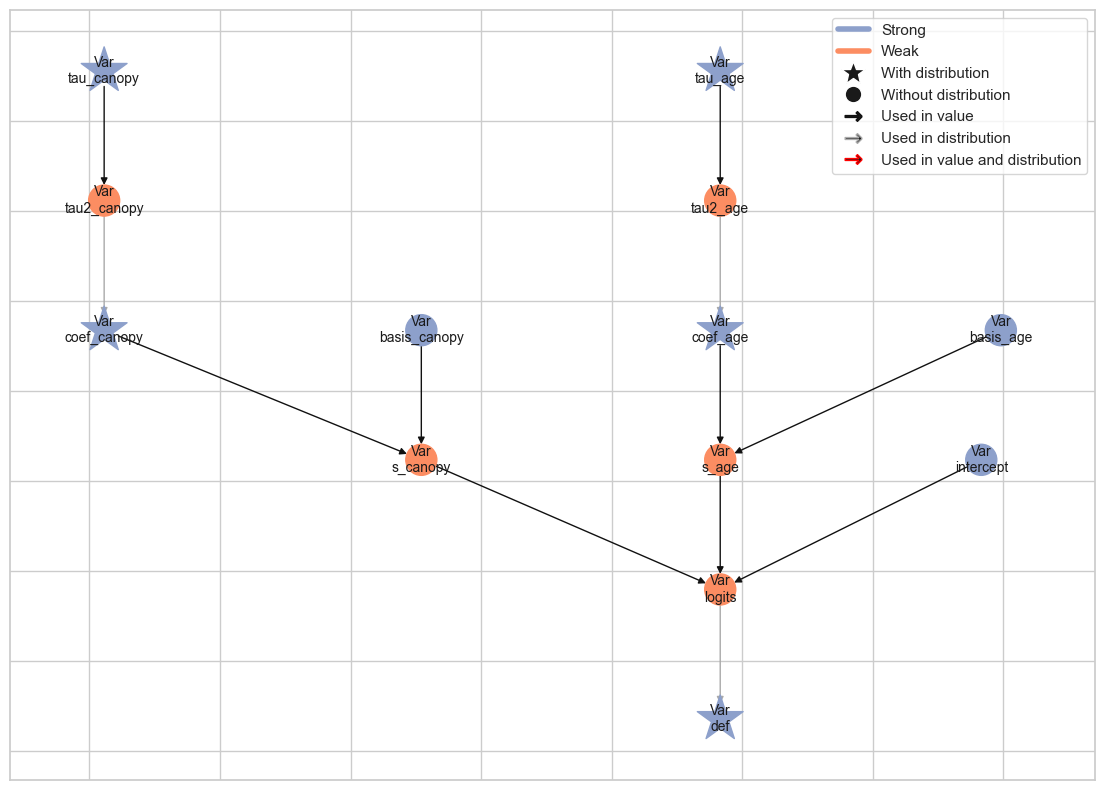

In [35]:
def_.plot_vars()

In [36]:
model2 = lsl.Model([def_])
interface = gs.LieselInterface(model2)

In [37]:
import optax

# crude, but robust optimization
preopt = gs.optim_flat(
    model_train=model2,
    params=[intercept.name, coef_age.name, coef_canopy.name],
    stopper=gs.Stopper(max_iter=10_000, patience=10, atol=1e-3),
    optimizer=optax.adam(learning_rate=0.01)
)

Training loss: 1270.066, Validation loss: 1270.066:   0%|          | 0/10000 [00:00<?, ?it/s]

Training loss: 971.889, Validation loss: 971.889:  64%|██████▍   | 6382/10000 [00:31<00:16, 214.31it/s] 

In [38]:
eb = gs.EngineBuilder(seed=42, num_chains=4)

eb.set_model(interface)
eb.set_initial_values(preopt.model_state)

eb.add_kernel(gs.NUTSKernel([intercept.name]))

eb.add_kernel(gs.IWLSKernel([coef_age.name]))
eb.add_kernel(gs.IWLSKernel([coef_canopy.name]))

eb.add_kernel(gs.NUTSKernel([var_param_age.name]))
eb.add_kernel(gs.NUTSKernel([var_param_canopy.name]))

eb.positions_included = [s_age.name, s_canopy.name]

eb.set_duration(warmup_duration=2000, posterior_duration=4000, thinning_posterior=10)

In [39]:
engine = eb.build()

liesel.goose.builder - WARNING - No jitter functions provided. The initial values won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done


In [40]:
engine.sample_all_epochs()

liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 75 transitions, 25 jitted together


100%|██████████████████████████████████████████| 3/3 [00:14<00:00,  4.87s/chunk]0:44<00:16, 214.31it/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 1, 1, 2, 2 / 75 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_01: 1, 0, 0, 1 / 75 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_02: 6, 0, 0, 2 / 75 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_03: 8, 7, 10, 7 / 75 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_04: 4, 11, 7, 7 / 75 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 634.83chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 2, 1, 1, 1 / 25 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_01: 1, 1, 1, 1 / 25 transitions
liesel.goose.engine - WARNIN

In [41]:
results2 = engine.get_results()
samples2 = results2.get_posterior_samples()
summary2 = gs.Summary(results2, deselected=eb.positions_included)

In [42]:
summary2

Parameter summary:

                      kernel      mean        sd    q_0.05     q_0.5  \
parameter   index                                                      
coef_age    (0,)   kernel_01 -0.522817  0.748374 -1.796976 -0.448926   
            (1,)   kernel_01  1.279320  0.986595 -0.042938  1.150901   
            (2,)   kernel_01  0.138058  0.902371 -1.225401  0.111846   
            (3,)   kernel_01 -0.299133  0.906336 -1.722809 -0.309932   
            (4,)   kernel_01 -0.280000  0.876853 -1.803912 -0.195706   
            (5,)   kernel_01  1.377207  0.778823  0.298273  1.287675   
            (6,)   kernel_01  0.163444  0.505813 -0.515738  0.108636   
            (7,)   kernel_01 -0.736355  0.242426 -1.140499 -0.710268   
            (8,)   kernel_01  3.247011  4.210583 -2.443515  2.792854   
coef_canopy (0,)   kernel_02  0.047473  0.239775 -0.275799  0.030755   
            (1,)   kernel_02 -0.043665  0.245995 -0.430345 -0.015217   
            (2,)   kernel_02 -0.120976  0.215239 -0.488082 -0.095042   
            (3,)   kernel_02  0.070082  0.208824 -0.230341  0.068027   
            (4,)   kernel_02  0.037169  0.188073 -0.226439  0.021563   
            (5,)   kernel_02  0.089402  0.170109 -0.204947  0.101041   
            (6,)   kernel_02  0.202872  0.144858  0.018954  0.181720   
            (7,)   kernel_02  0.039096  0.070467 -0.055547  0.030632   
            (8,)   kernel_02 -0.723913  1.917965 -3.334581 -0.964045   
intercept   ()     kernel_00 -0.428095  0.039960 -0.494975 -0.426540   
tau_age     ()     kernel_03  1.138890  0.660442  0.410930  1.009775   
tau_canopy  ()     kernel_04  0.212481  0.154427  0.072123  0.171619   

                      q_0.95  sample_size     ess_bulk     ess_tail      rhat  
parameter   index                                                              
coef_age    (0,)    0.552570         1600   813.173997  1151.632872  1.003572  
            (1,)    3.056268         1600   557.697024   951.821869  1.002773  
            (2,)    1.566111         1600   969.428965  1061.648609  1.007095  
            (3,)    1.065736         1600  1135.959150   983.400340  1.003932  
            (4,)    0.937529         1600   993.054187  1159.187605  1.010779  
            (5,)    2.690998         1600   735.502790   990.583403  1.005229  
            (6,)    1.089090         1600   911.196725  1167.085730  1.009476  
            (7,)   -0.380356         1600   536.107939   863.228765  1.003144  
            (8,)   10.943625         1600   902.973292  1123.835335  1.008565  
coef_canopy (0,)    0.425958         1600   975.301089   802.676273  1.003348  
            (1,)    0.281794         1600  1052.707867   872.351586  1.002455  
            (2,)    0.163493         1600   930.262977   649.187463  1.007430  
            (3,)    0.385930         1600  1146.540597  1218.279925  1.002698  
            (4,)    0.352376         1600  1164.180813   918.158810  1.003687  
            (5,)    0.318285         1600  1050.562170   912.735799  1.005810  
            (6,)    0.448047         1600   669.721522   883.991665  1.006782  
            (7,)    0.163193         1600   815.699818   708.108374  1.005507  
            (8,)    2.755343         1600   546.071961   747.141367  1.005087  
intercept   ()     -0.361967         1600   880.709115  1423.533598  1.007095  
tau_age     ()      2.296307         1600   334.361139   494.150685  1.004666  
tau_canopy  ()      0.479505         1600   332.438199   541.489683  1.011550  

Error summary:

                                                    count  relative
kernel    error_code error_msg            phase                    
kernel_00 1          divergent transition warmup       59  0.007375
                                          posterior     0       0.0
kernel_01 90         nan acceptance prob  warmup       29  0.003625
                                          posterior     1  0.000625
kernel_02 90         nan acceptance prob  warmup       27 

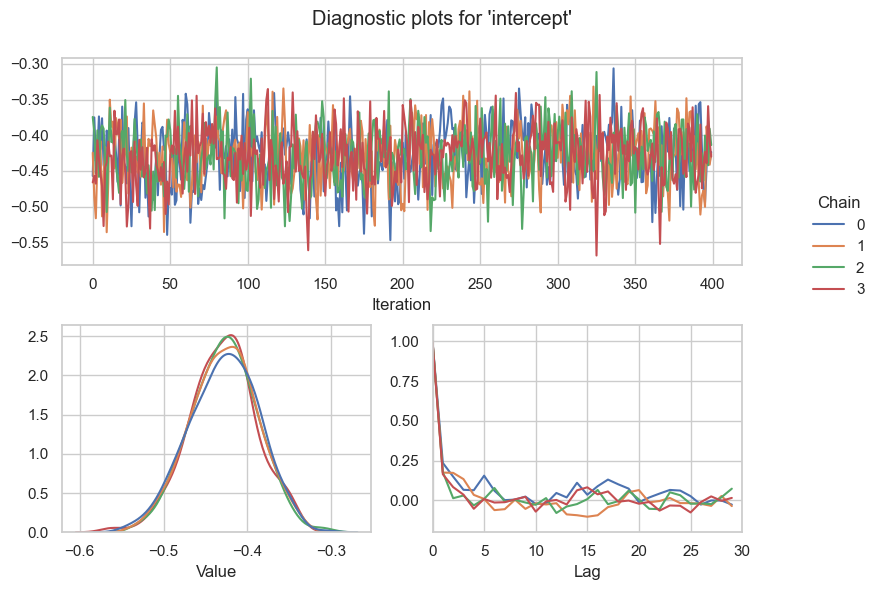

In [43]:
gs.plot_param(results2, "intercept")

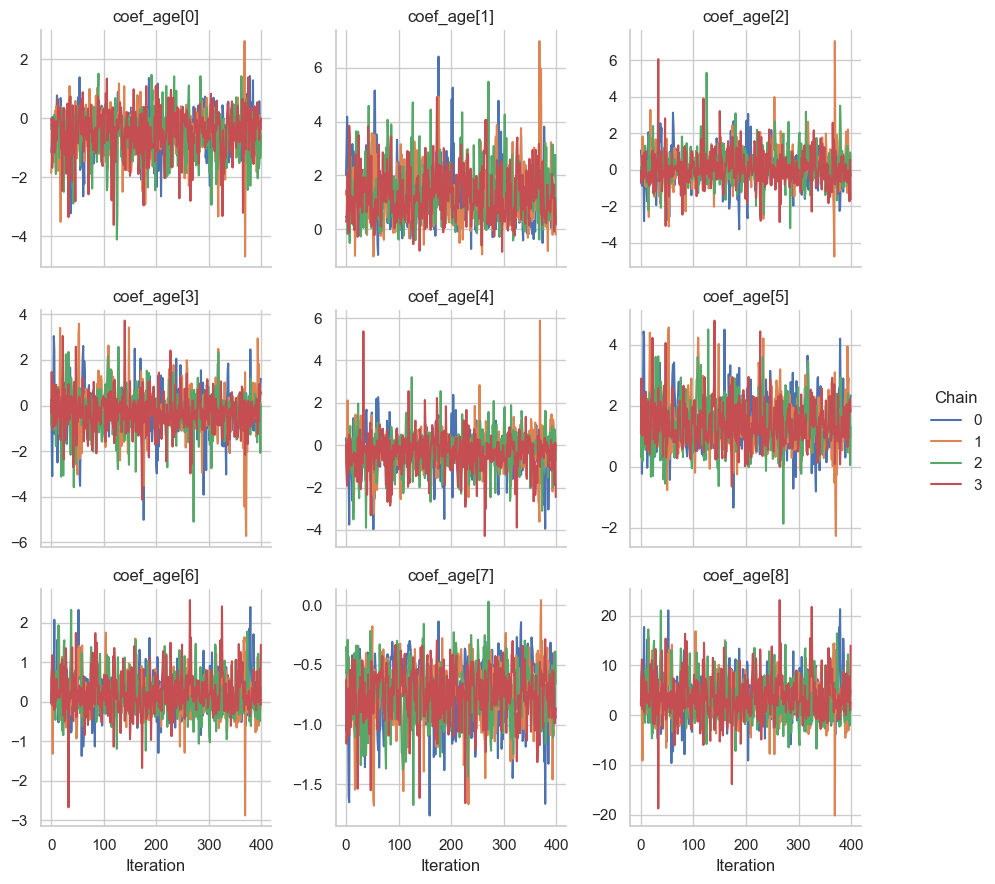

In [44]:
gs.plot_trace(results2, "coef_age")

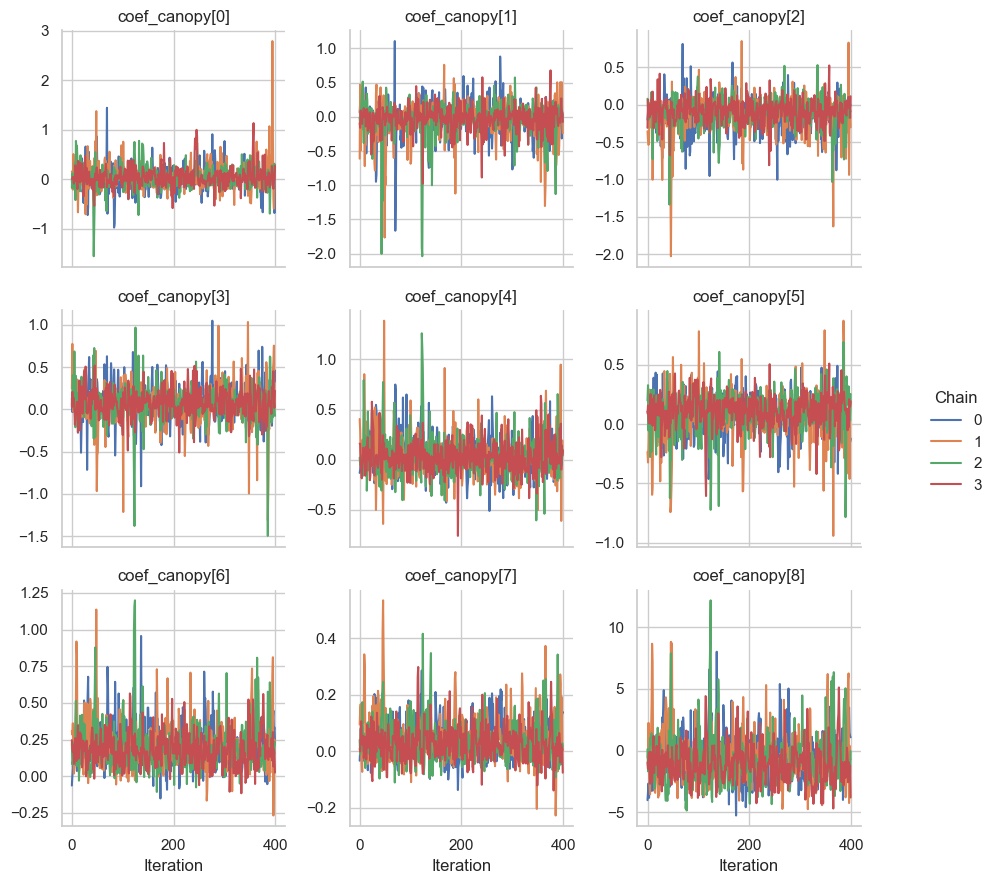

In [45]:
gs.plot_trace(results2, "coef_canopy")

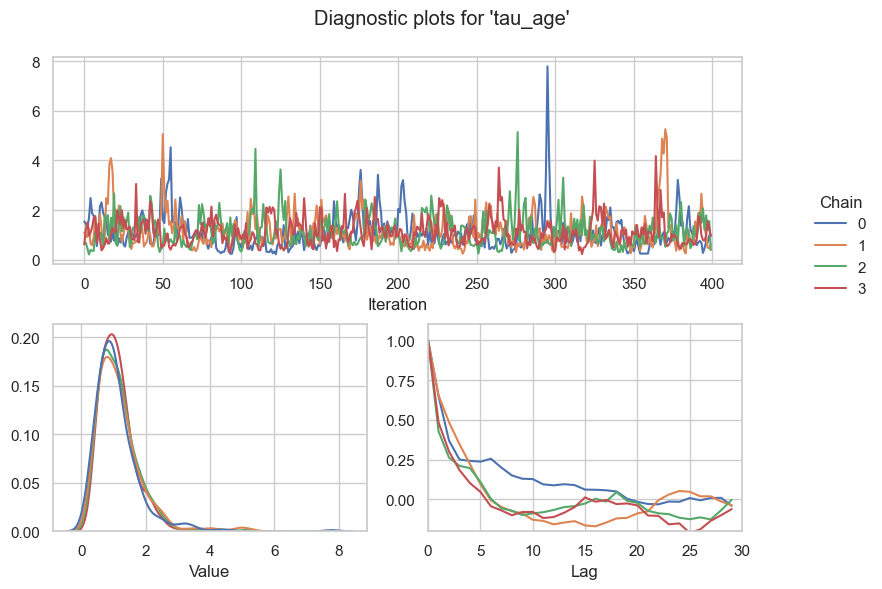

In [46]:
try:
    gs.plot_param(results2, "tau2_age")
except KeyError:
    gs.plot_param(results2, "tau_age")

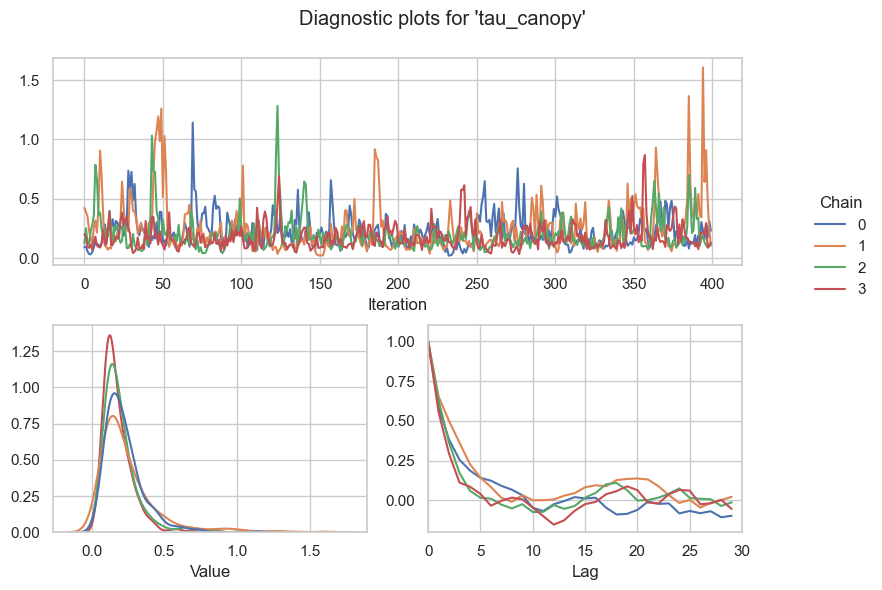

In [47]:
try:
    gs.plot_param(results2, "tau2_canopy")
except KeyError:
    gs.plot_param(results2, "tau_canopy")

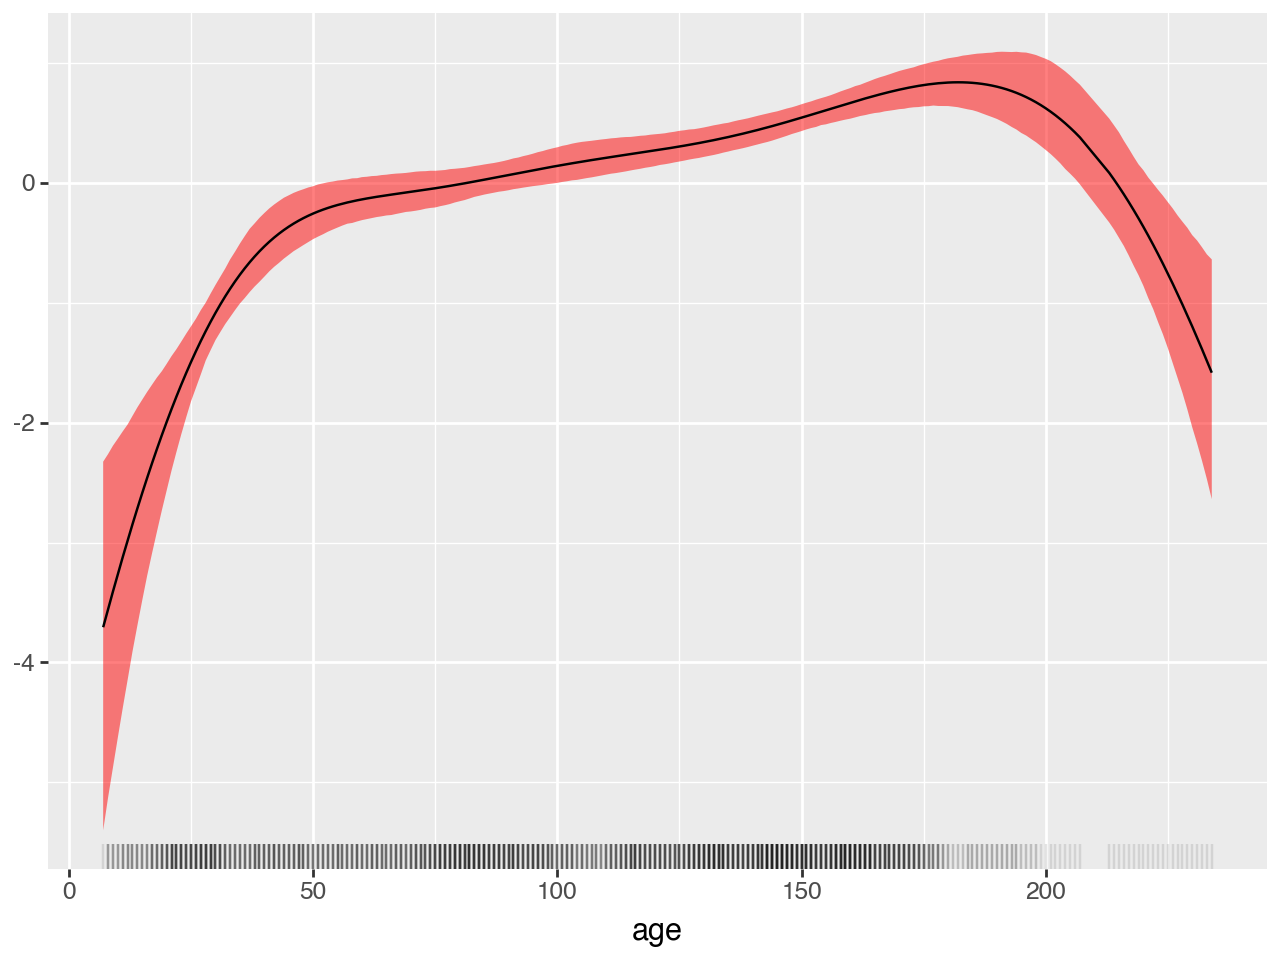

In [48]:
age_samples = np.asarray(samples2[s_age.name]) # convert to numpy array for plotting

s_age_mean = np.mean(samples2[s_age.name], axis=(0, 1))
s_age_lo = np.quantile(samples2[s_age.name], 0.025, axis=(0, 1))
s_age_hi = np.quantile(samples2[s_age.name], 0.975, axis=(0, 1))

(
    p9.ggplot()
    + p9.geom_ribbon(p9.aes(x=forest["age"], ymin=s_age_lo, ymax=s_age_hi), alpha=0.5, fill = "red")
    + p9.geom_line(p9.aes(x=forest["age"], y=s_age_mean))
    + p9.geom_rug(p9.aes(x=forest["age"]), alpha = 0.1)
)

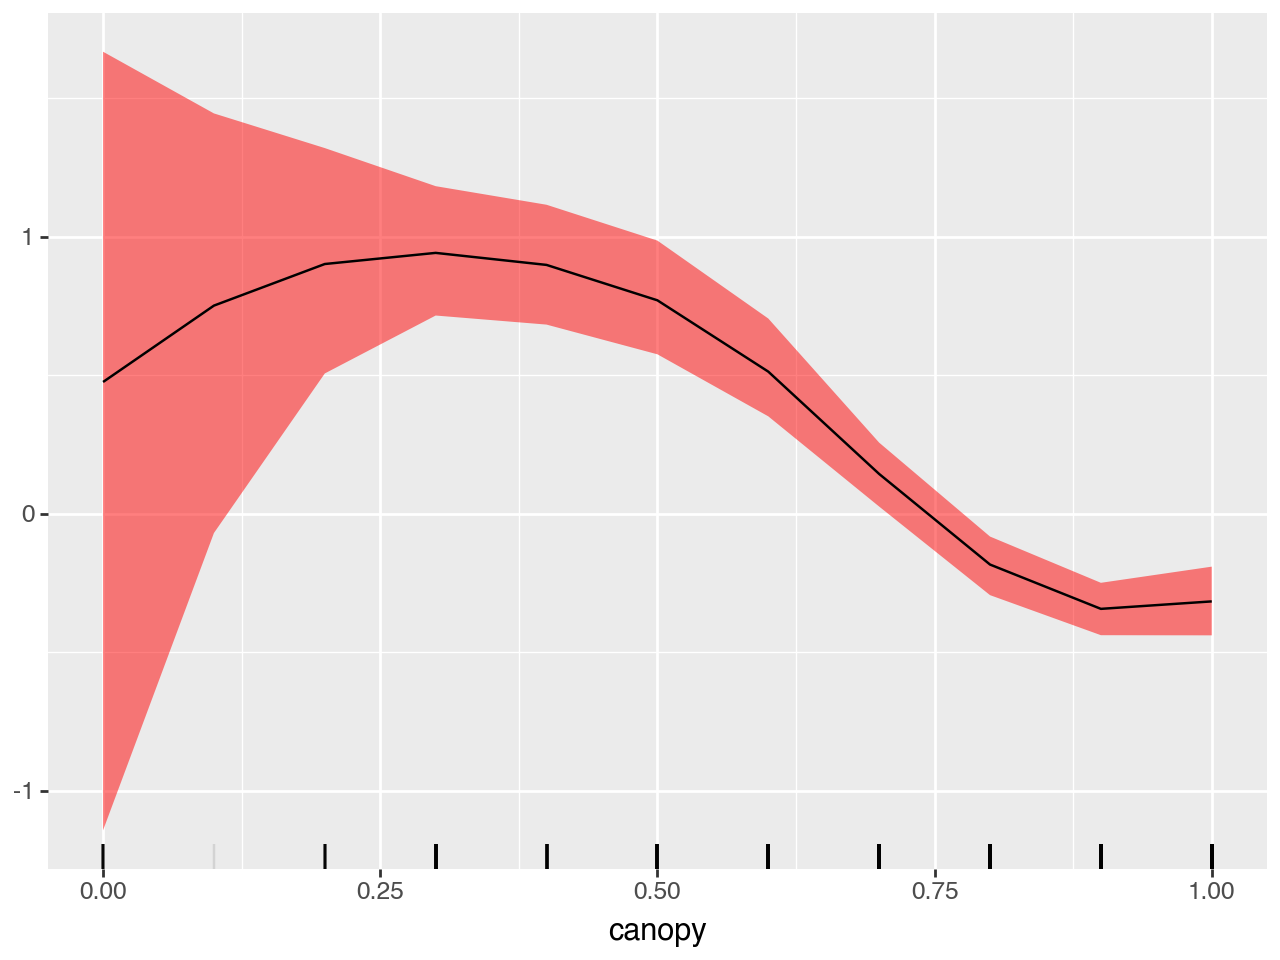

In [49]:
bmi_samples = np.asarray(samples2[s_canopy.name]) # convert to numpy for plotting

s_canopy_mean = np.mean(samples2[s_canopy.name], axis=(0, 1))
s_canopy_lo = np.quantile(samples2[s_canopy.name], 0.025, axis=(0, 1))
s_canopy_hi = np.quantile(samples2[s_canopy.name], 0.975, axis=(0, 1))

(
    p9.ggplot()
    + p9.geom_ribbon(p9.aes(x=forest["canopy"], ymin=s_canopy_lo, ymax=s_canopy_hi), alpha=0.5, fill = "red")
    + p9.geom_line(p9.aes(x=forest["canopy"], y=s_canopy_mean))
    + p9.geom_rug(p9.aes(x=forest["canopy"]), alpha = 0.1)
)

# Model 3: With Random Intercept

In [50]:
_ = model2.pop_nodes_and_vars()

In [51]:
%%R
forest$id  <- as.factor(forest$id)

In [52]:
%%R -o basis_id_r,pen_id_r
# set up basis matrix and penalty matrix in magcv

s_id <- mgcv::smoothCon(
    s(id, bs="re"),
    data = forest,
    knots = NULL,
    absorb.cons = TRUE
)

# basis_id_r <- s_id[[1]]$X
# pen_id_r <- s_id[[1]]$S[[1]]

# optional diagonalization of the penalty matrix
s_id <- s_id[[1]] |> mgcv::smooth2random(vnames = "", type = 2)

basis_id_r <- cbind(s_id$rand$Xr, s_id$Xf)
pen_id_r <- diag(s_id$pen.ind)

In [53]:
# get R objects into python
basis_id_r = robjects.globalenv['basis_id_r']
pen_id_r = robjects.globalenv['pen_id_r']

In [54]:
# set up structured additive term in liesel
basis_id = lsl.Var.new_obs(basis_id_r, name="basis_id")

mvnd = MVND.from_penalty(loc=0.0, var=1.0, pen=pen_id_r)

# set up tau2 prior and variable
# tau2_id_prior = lsl.Dist(tfd.InverseGamma, concentration=0.01, scale=0.01)
# tau2_id = lsl.Var.new_param(10.0, tau2_id_prior, name="tau2_id")
# var_param_id = tau2_id

# A diffuse prior with nonzero density at zero
# The scale can be set according to the principles of a scale-dependent prior
# See Klein & Kneib (2016) for details
tau_id_prior = lsl.Dist(tfd.Weibull, concentration=0.5, scale=20.0)
tau_id = lsl.Var.new_param(10.0, tau_id_prior, name="tau_id")
tau2_id = lsl.Var.new_calc(jnp.square, tau_id, name="tau2_id")
var_param_id = tau_id

# set up coefficient prior
coef_id_prior = lsl.Dist(
    MVND.from_penalty,
    loc=0.0,
    var=tau2_id,
    pen=pen_id_r,
    rank=mvnd.rank,
    log_pdet=mvnd.log_pdet
)

# set up coefficient variable
coef_id = lsl.Var.new_param(
    value=jnp.zeros(basis_id_r.shape[1]),
    distribution=coef_id_prior,
    name="coef_id"
)

# set up effect variable
s_id = lsl.Var.new_calc(jnp.dot, basis_id, coef_id, name="s_id")

In [55]:
intercept = lsl.Var.new_param(
    logit(forest["def"].mean()), # crude starting value
    name="intercept"
)

logits = lsl.Var.new_calc(lambda *args: sum(args), intercept, s_age, s_canopy, s_id, name="logits")

def_dist = lsl.Dist(tfd.Bernoulli, logits=logits)
def_ = lsl.Var.new_obs(forest["def"].values, distribution=def_dist, name="def")

In [56]:
model3 = lsl.Model([def_])
interface = gs.LieselInterface(model3)

liesel.model.model - INFO - Converted dtype of Value(name="").value
liesel.model.model - INFO - Converted dtype of Value(name="basis_id_value").value


In [57]:
import optax

# crude, but robust optimization
preopt = gs.optim_flat(
    model_train=model3,
    params=[intercept.name, coef_age.name, coef_canopy.name, coef_id.name],
    stopper=gs.Stopper(max_iter=10_000, patience=10, atol=1e-3),
    optimizer=optax.adam(learning_rate=0.01)
)

Training loss: 1522.517, Validation loss: 1522.517:   0%|          | 0/10000 [00:00<?, ?it/s]

Training loss: 910.876, Validation loss: 910.875:  42%|████▏     | 4180/10000 [00:28<00:36, 158.02it/s] 

In [58]:
eb = gs.EngineBuilder(seed=42, num_chains=4)

eb.set_model(interface)
eb.set_initial_values(preopt.model_state)

eb.add_kernel(gs.NUTSKernel([intercept.name]))

eb.add_kernel(gs.IWLSKernel([coef_age.name]))
eb.add_kernel(gs.IWLSKernel([coef_canopy.name]))
eb.add_kernel(gs.NUTSKernel([coef_id.name]))

eb.add_kernel(gs.NUTSKernel([var_param_age.name]))
eb.add_kernel(gs.NUTSKernel([var_param_canopy.name]))
eb.add_kernel(gs.NUTSKernel([var_param_id.name]))

eb.positions_included = [s_age.name, s_canopy.name, s_id.name]

eb.set_duration(warmup_duration=2000, posterior_duration=4000, thinning_posterior=10)

In [59]:
engine = eb.build()

liesel.goose.builder - WARNING - No jitter functions provided. The initial values won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done


In [60]:
engine.sample_all_epochs()

liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 75 transitions, 25 jitted together
100%|██████████████████████████████████████████| 3/3 [00:11<00:00,  3.99s/chunk]0:42<00:36, 158.02it/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 1, 2, 1, 1 / 75 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_03: 1, 1, 0, 1 / 75 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_04: 6, 9, 8, 7 / 75 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_05: 12, 7, 12, 13 / 75 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_06: 3, 3, 4, 3 / 75 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 416.51chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 1, 1, 1, 2 / 25 transitions
liesel.goose.engine - 

In [61]:
results3 = engine.get_results()
samples3 = results3.get_posterior_samples()
summary3 = gs.Summary(results3, deselected=eb.positions_included)

In [62]:
summary3

Parameter summary:

                     kernel      mean        sd    q_0.05     q_0.5    q_0.95  \
parameter  index                                                                
coef_age   (0,)   kernel_01  3.078769  2.123490 -0.021598  2.928542  6.732805   
           (1,)   kernel_01  0.920973  2.241695 -2.443204  0.823847  4.915545   
           (2,)   kernel_01  2.309980  2.320709 -1.230516  2.275080  5.956386   
           (3,)   kernel_01 -1.222764  2.226934 -4.590664 -1.293761  2.244961   
           (4,)   kernel_01 -0.604645  2.176549 -3.979686 -0.549507  2.625035   
...                     ...       ...       ...       ...       ...       ...   
coef_id    (82,)  kernel_03  1.570044  0.625651  0.576398  1.578635  2.603504   
intercept  ()     kernel_00 -1.056698  0.294949 -1.548656 -1.057808 -0.585552   
tau_age    ()     kernel_04  2.884752  1.413275  1.359732  2.580656  5.202056   
tau_canopy ()     kernel_05  0.150517  0.165554  0.004299  0.099270  0.482843   
tau_id     ()     kernel_06  2.575239  0.356973  2.046447  2.556149  3.217198   

                  sample_size    ess_bulk    ess_tail      rhat  
parameter  index                                                 
coef_age   (0,)          1600  534.790878  843.406275  1.001743  
           (1,)          1600  632.947408  752.305149  1.003886  
           (2,)          1600  830.736030  797.137220  1.007949  
           (3,)          1600  896.812374  988.524032  1.003757  
           (4,)          1600  840.689521  945.050173  1.010382  
...                       ...         ...         ...       ...  
coef_id    (82,)         1600  356.034134  697.334149  1.010020  
intercept  ()            1600  287.194612  642.524403  1.014893  
tau_age    ()            1600  433.923624  715.583007  1.003380  
tau_canopy ()            1600   26.229376   11.749179  1.115024  
tau_id     ()            1600  129.164480  610.817460  1.027861  

[105 rows x 10 columns]

Error summary:

                                                    count  relative
kernel    error_code error_msg            phase                    
kernel_00 1          divergent transition warmup       72     0.009
                                          posterior     0       0.0
kernel_03 1          divergent transition warmup       31  0.003875
                                          posterior     0       0.0
kernel_04 1          divergent transition warmup      393  0.049125
                                          posterior   224      0.14
kernel_05 1          divergent transition warmup      455  0.056875
                                          posterior  1063  0.664375
          2          maximum tree depth   warmup        0       0.0
                                          posterior   117  0.073125
kernel_06 1          divergent transition warmup       74   0.00925
                                          posterior     0       0.0

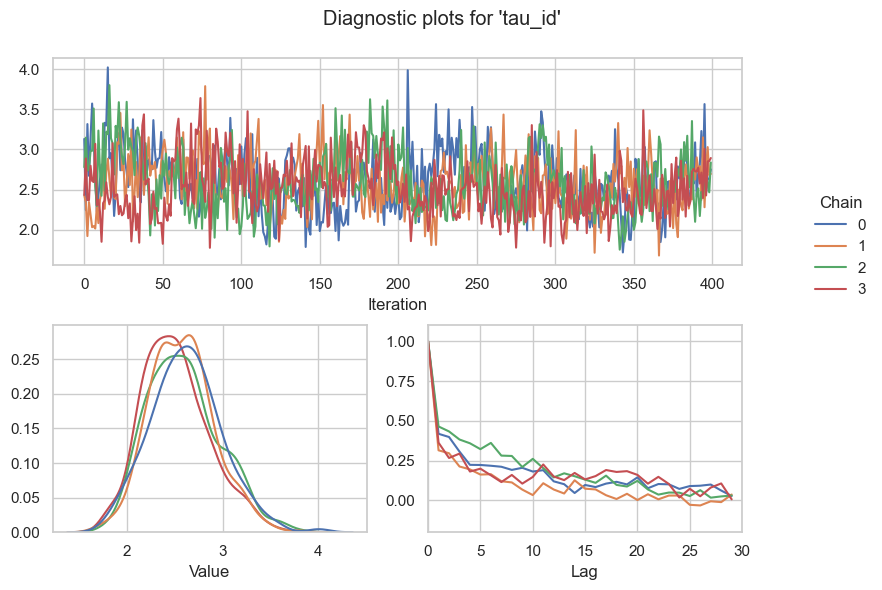

In [63]:
try:
    gs.plot_param(results3, "tau2_id")
except KeyError:
    gs.plot_param(results3, "tau_id")

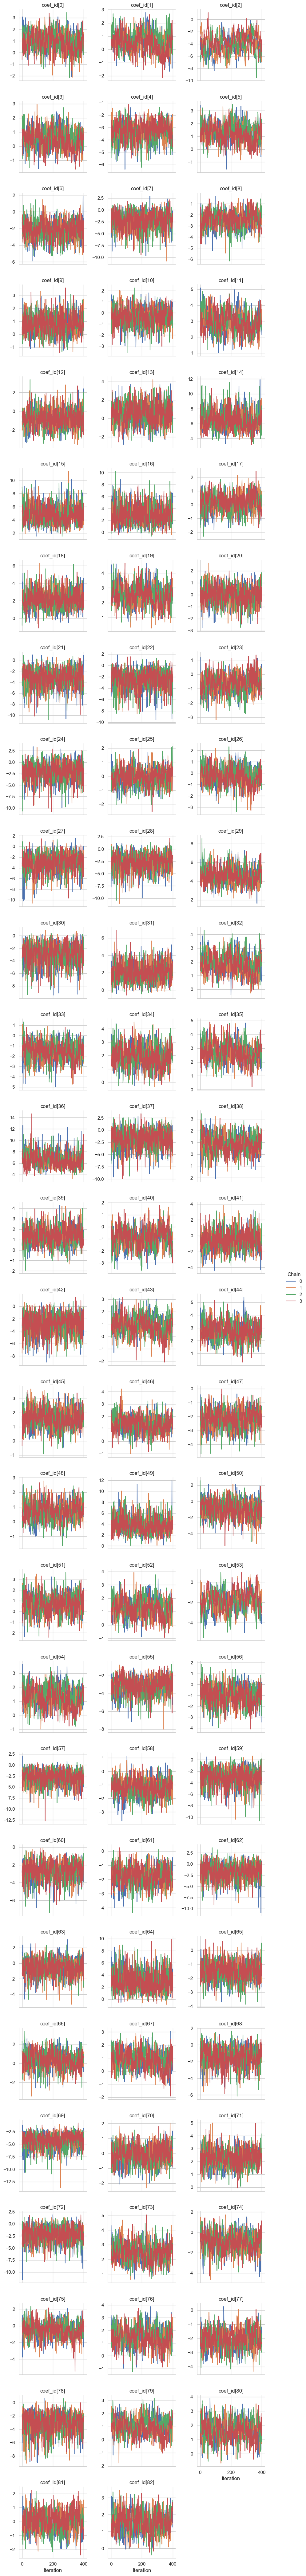

In [64]:
gs.plot_trace(results3, "coef_id")

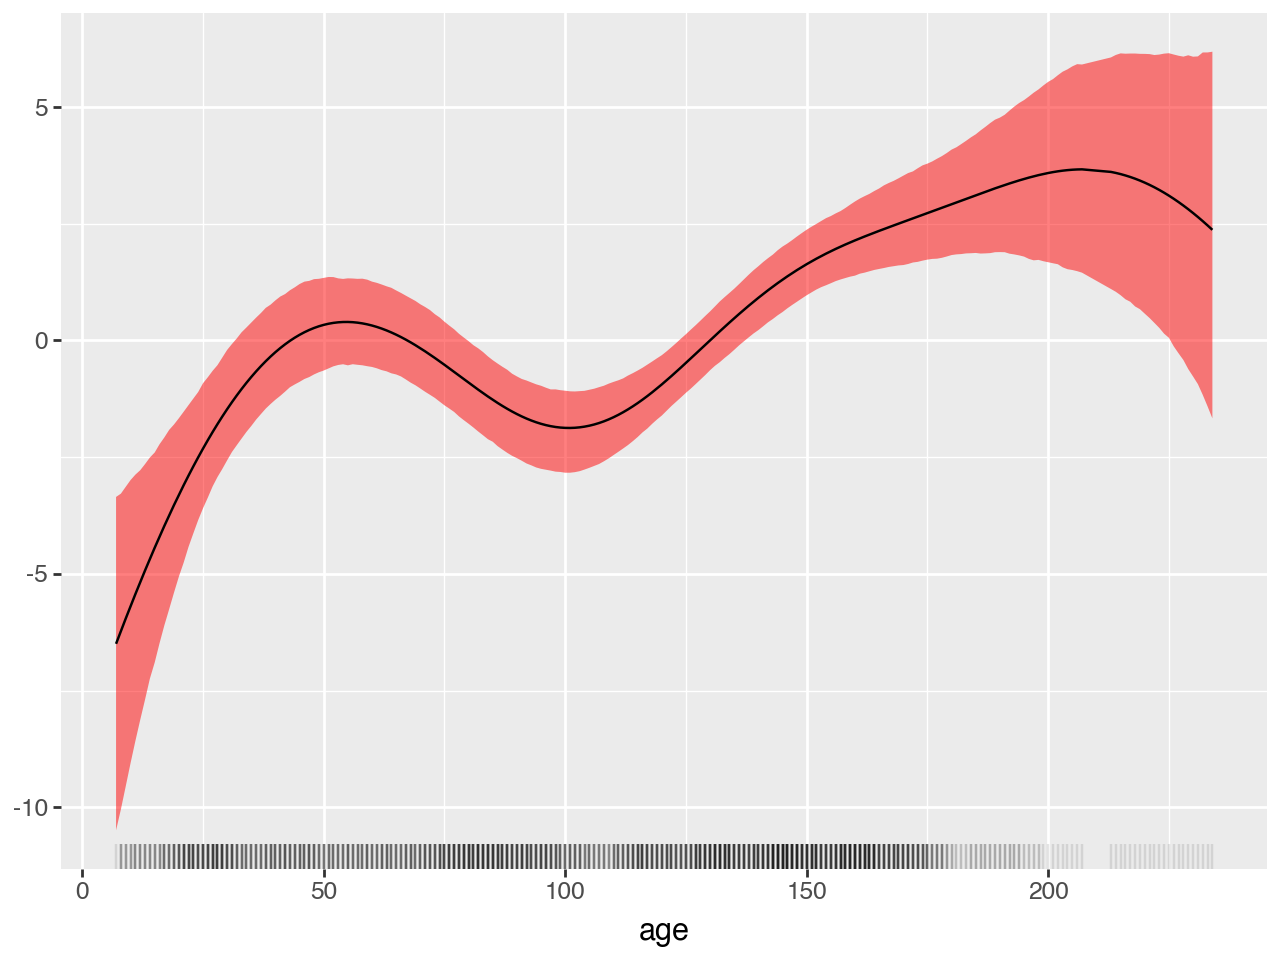

In [65]:
age_samples = np.asarray(samples3[s_age.name]) # convert to numpy array for plotting

s_age_mean = np.mean(samples3[s_age.name], axis=(0, 1))
s_age_lo = np.quantile(samples3[s_age.name], 0.025, axis=(0, 1))
s_age_hi = np.quantile(samples3[s_age.name], 0.975, axis=(0, 1))

(
    p9.ggplot()
    + p9.geom_ribbon(p9.aes(x=forest["age"], ymin=s_age_lo, ymax=s_age_hi), alpha=0.5, fill = "red")
    + p9.geom_line(p9.aes(x=forest["age"], y=s_age_mean))
    + p9.geom_rug(p9.aes(x=forest["age"]), alpha = 0.1)
)

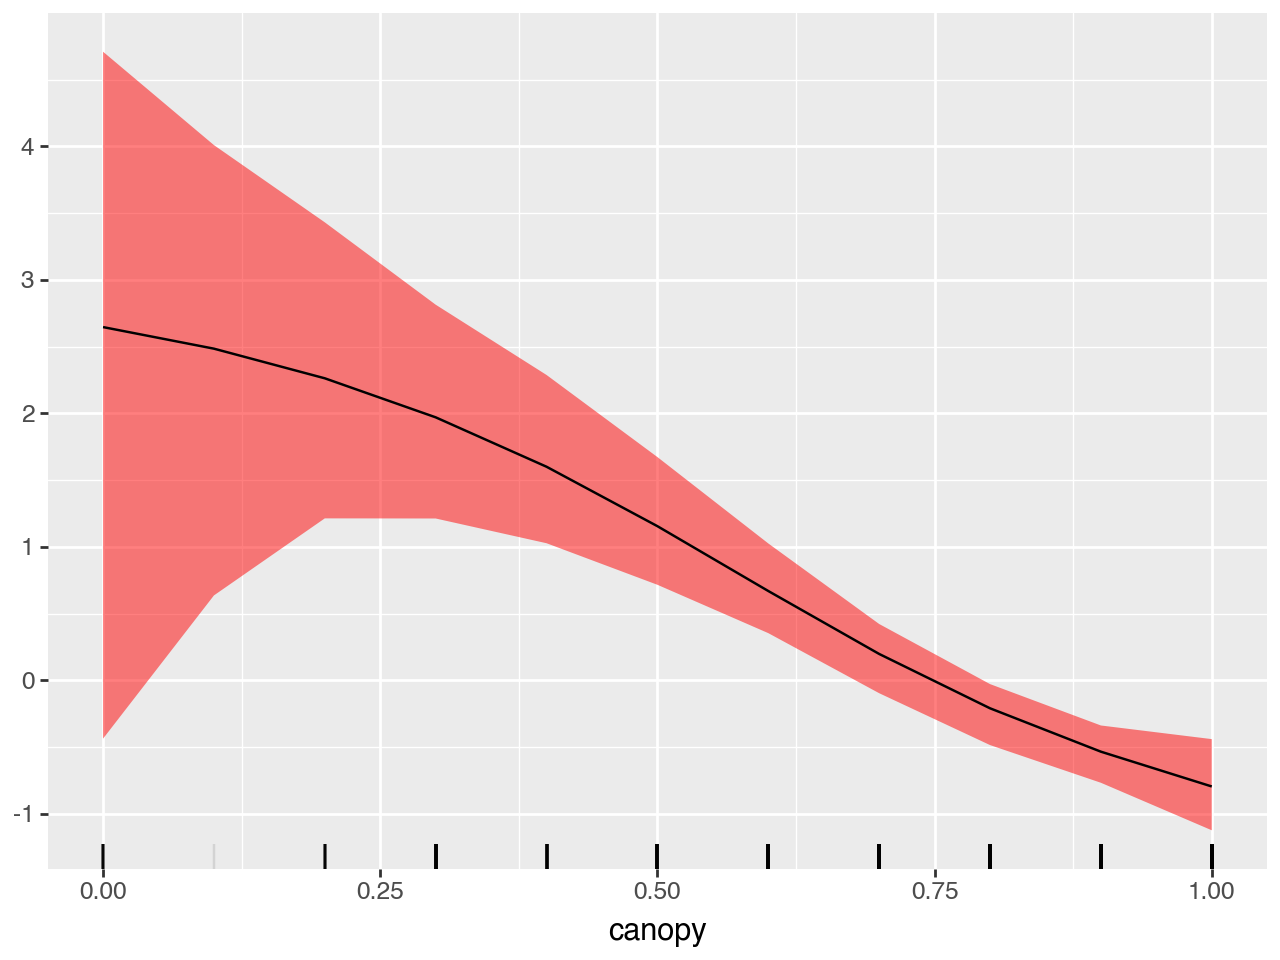

In [66]:
bmi_samples = np.asarray(samples3[s_canopy.name]) # convert to numpy for plotting

s_canopy_mean = np.mean(samples3[s_canopy.name], axis=(0, 1))
s_canopy_lo = np.quantile(samples3[s_canopy.name], 0.025, axis=(0, 1))
s_canopy_hi = np.quantile(samples3[s_canopy.name], 0.975, axis=(0, 1))

(
    p9.ggplot()
    + p9.geom_ribbon(p9.aes(x=forest["canopy"], ymin=s_canopy_lo, ymax=s_canopy_hi), alpha=0.5, fill = "red")
    + p9.geom_line(p9.aes(x=forest["canopy"], y=s_canopy_mean))
    + p9.geom_rug(p9.aes(x=forest["canopy"]), alpha = 0.1)
)

In [67]:
# select samples for unique clusters
unique_id = forest.reset_index().drop_duplicates(subset="id")
ids = unique_id["id"].values
i = unique_id["index"].astype(int).values - 1

s_id_samples = np.asarray(samples3[s_id.name][..., i])

# select samples for unique id
s_id_samples = np.asarray(samples3[s_id.name][..., i])

# compute posterior summaries
s_id_mean = np.mean(s_id_samples, axis=(0, 1))
s_id_lo = np.quantile(s_id_samples, 0.025, axis=(0, 1))
s_id_hi = np.quantile(s_id_samples, 0.975, axis=(0, 1))

# collect in data frame
ids = pd.DataFrame({
    "ids": ids,
    "s_id_mean": s_id_mean,
    "s_id_lo": s_id_lo,
    "s_id_hi": s_id_hi
})



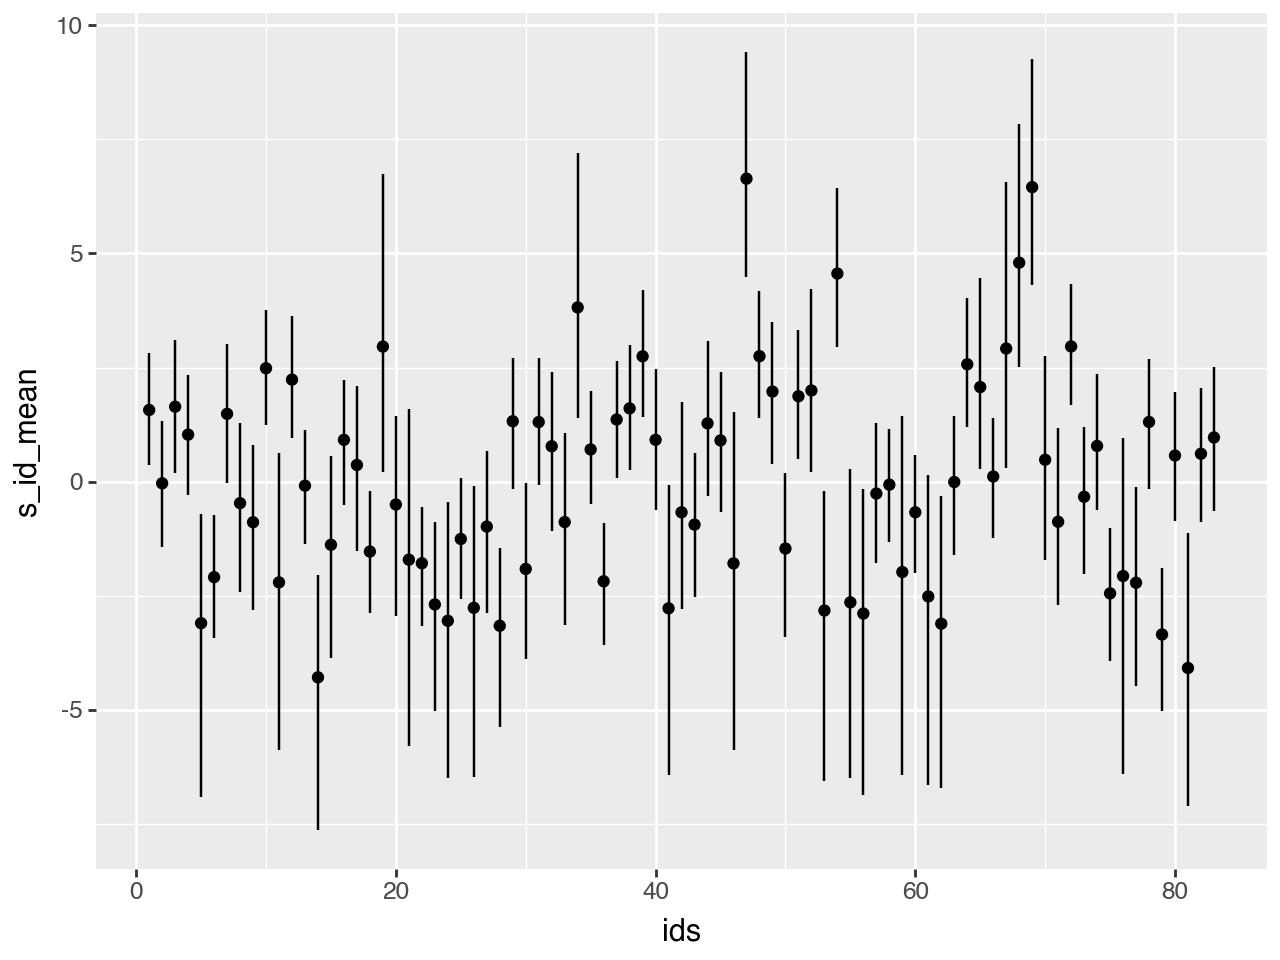

In [68]:
(
    p9.ggplot(ids)
    + p9.geom_linerange(p9.aes(x="ids", ymin="s_id_lo", ymax="s_id_hi"))
    + p9.geom_point(p9.aes(x="ids", y="s_id_mean"))
)

In [69]:
# turn ids into categorical
ids["ids"] = pd.Categorical(ids["ids"], categories=ids["ids"].values)

In [70]:
ids["ids"]

0      5
1      1
2     11
3      8
4      4
      ..
78    81
79    80
80    79
81    83
82    82
Name: ids, Length: 83, dtype: category
Categories (83, int64): [5, 1, 11, 8, ..., 80, 79, 83, 82]

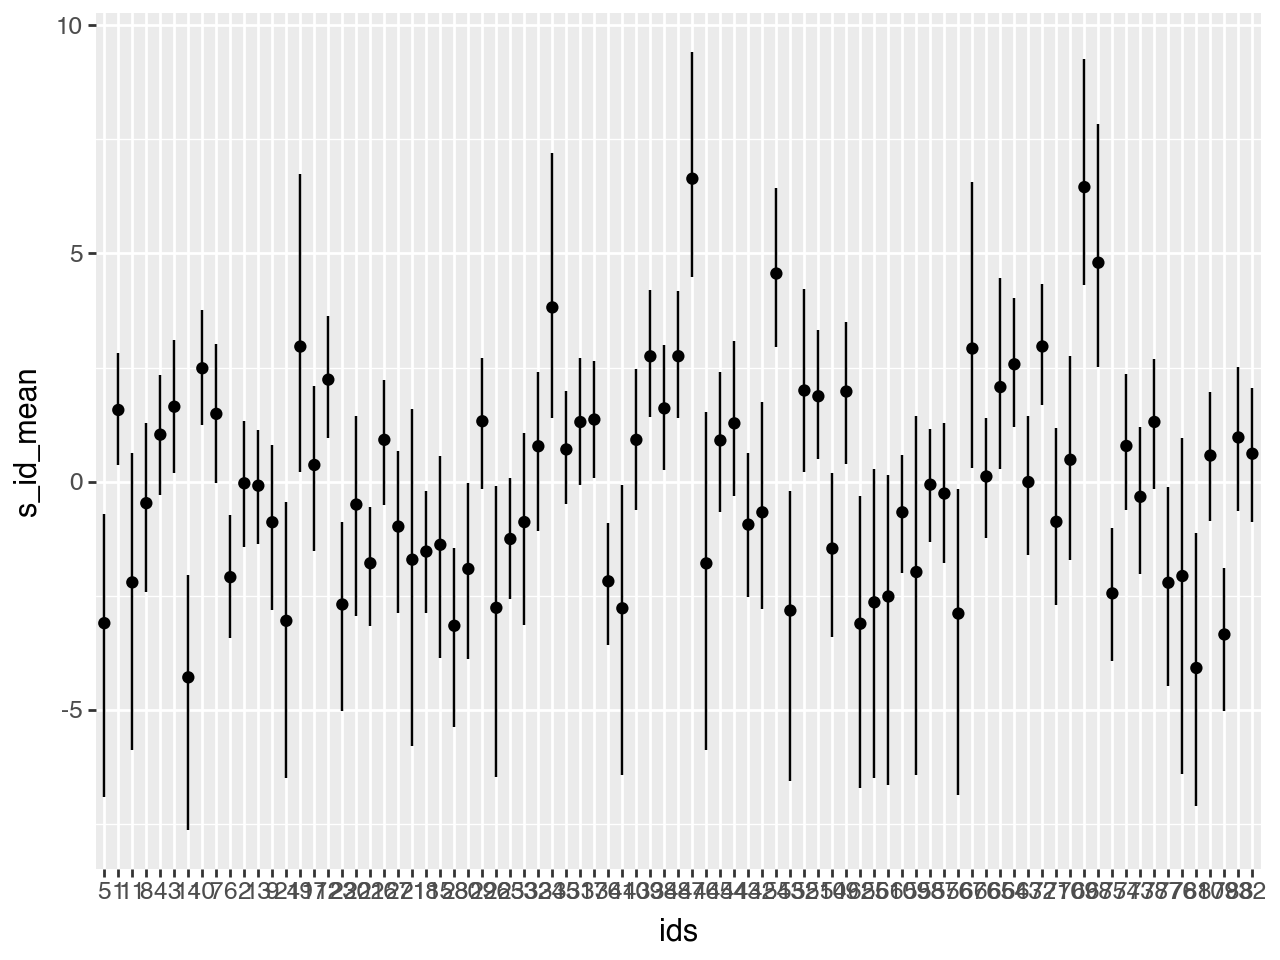

In [71]:
(
    p9.ggplot(ids)
    + p9.geom_linerange(p9.aes(x="ids", ymin="s_id_lo", ymax="s_id_hi"))
    + p9.geom_point(p9.aes(x="ids", y="s_id_mean"))
)

# Model 4: With Spatial Effect

In [72]:
_ = model3.pop_nodes_and_vars()

In [73]:
%%R -o basis_spatial_r,pen_spatial_r
# set up basis matrix and penalty matrix in magcv

s_spatial <- mgcv::smoothCon(
    s(x,y),
    data = forest,
    knots = NULL,
    absorb.cons = TRUE
)

# basis_spatial_r <- s_spatial[[1]]$X
# pen_spatial_r <- s_spatial[[1]]$S[[1]]

# optional diagonalization of the penalty matrix
s_spatial <- s_spatial[[1]] |> mgcv::smooth2random(vnames = "", type = 2)

basis_spatial_r <- cbind(s_spatial$rand$Xr, s_spatial$Xf)
pen_spatial_r <- diag(s_spatial$pen.ind)

In [74]:
# get R objects into python
basis_spatial_r = robjects.globalenv['basis_spatial_r']
pen_spatial_r = robjects.globalenv['pen_spatial_r']

In [75]:
# set up structured additive term in liesel
basis_spatial = lsl.Var.new_obs(basis_spatial_r, name="basis_spatial")

mvnd = MVND.from_penalty(loc=0.0, var=1.0, pen=pen_spatial_r)

# set up tau2 prior and variable
# tau2_spatial_prior = lsl.Dist(tfd.InverseGamma, concentration=0.01, scale=0.01)
# tau2_spatial = lsl.Var.new_param(10.0, tau2_spatial_prior, name="tau2_spatial")
# var_param_spatial = tau2_spatial

# A diffuse prior with nonzero density at zero
# The scale can be set according to the principles of a scale-dependent prior
# See Klein & Kneib (2016) for details
tau_spatial_prior = lsl.Dist(tfd.Weibull, concentration=0.5, scale=20.0)
tau_spatial = lsl.Var.new_param(10.0, tau_spatial_prior, name="tau_spatial")
tau2_spatial = lsl.Var.new_calc(jnp.square, tau_spatial, name="tau2_spatial")
var_param_spatial = tau_spatial

# set up coefficient prior
coef_spatial_prior = lsl.Dist(
    MVND.from_penalty,
    loc=0.0,
    var=tau2_spatial,
    pen=pen_spatial_r,
    rank=mvnd.rank,
    log_pdet=mvnd.log_pdet
)

# set up coefficient variable
coef_spatial = lsl.Var.new_param(
    value=jnp.zeros(basis_spatial_r.shape[1]),
    distribution=coef_spatial_prior,
    name="coef_spatial"
)

# set up effect variable
s_spatial = lsl.Var.new_calc(jnp.dot, basis_spatial, coef_spatial, name="s_spatial")

In [76]:
intercept = lsl.Var.new_param(
    logit(forest["def"].mean()), # crude starting value
    name="intercept"
)

logits = lsl.Var.new_calc(lambda *args: sum(args), intercept, s_age, s_canopy, s_spatial, name="logits")

def_dist = lsl.Dist(tfd.Bernoulli, logits=logits)
def_ = lsl.Var.new_obs(forest["def"].values, distribution=def_dist, name="def")

liesel.model.model - INFO - Converted dtype of Value(name="").value
liesel.model.model - INFO - Converted dtype of Value(name="basis_spatial_value").value
liesel.model.nodes - INFO - Unnamed nodes were temporarily named for plottingThe automatically assigned names are: ['n12', 'n13', 'n14', 'n15', 'n16', 'n17']. The names are reset after plotting.


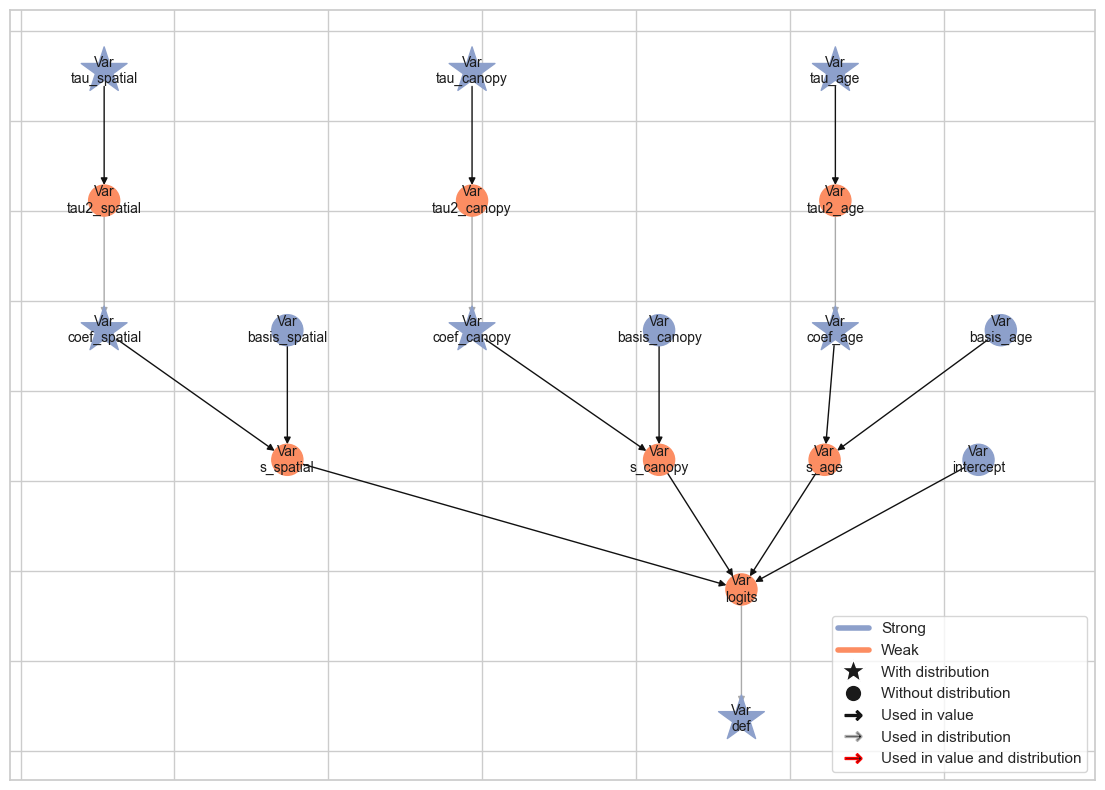

In [77]:
def_.plot_vars()

In [78]:
model4 = lsl.Model([def_])
interface = gs.LieselInterface(model4)

In [79]:
import optax

# crude, but robust optimization
preopt = gs.optim_flat(
    model_train=model4,
    params=[intercept.name, coef_age.name, coef_canopy.name, coef_spatial.name],
    stopper=gs.Stopper(max_iter=10_000, patience=10, atol=1e-3),
    optimizer=optax.adam(learning_rate=0.01)
)

Training loss: 913.560, Validation loss: 913.560:  43%|████▎     | 4286/10000 [00:27<00:35, 162.55it/s] 

In [80]:
eb = gs.EngineBuilder(seed=42, num_chains=4)

eb.set_model(interface)
eb.set_initial_values(preopt.model_state)

eb.add_kernel(gs.NUTSKernel([intercept.name]))

eb.add_kernel(gs.IWLSKernel([coef_age.name]))
eb.add_kernel(gs.IWLSKernel([coef_canopy.name]))
eb.add_kernel(gs.IWLSKernel([coef_spatial.name]))

eb.add_kernel(gs.NUTSKernel([var_param_age.name]))
eb.add_kernel(gs.NUTSKernel([var_param_canopy.name]))
eb.add_kernel(gs.NUTSKernel([var_param_spatial.name]))

eb.positions_included = [s_age.name, s_canopy.name, s_spatial.name]

eb.set_duration(warmup_duration=2000, posterior_duration=4000, thinning_posterior=10)

In [81]:
engine = eb.build()

liesel.goose.builder - WARNING - No jitter functions provided. The initial values won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done


In [82]:
engine.sample_all_epochs()

liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 75 transitions, 25 jitted together


100%|██████████████████████████████████████████| 3/3 [00:10<00:00,  3.56s/chunk]0:40<00:35, 162.55it/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 2, 1, 3, 1 / 75 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_04: 6, 9, 6, 4 / 75 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_05: 8, 13, 12, 8 / 75 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_06: 3, 6, 2, 1 / 75 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 544.08chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 1, 1, 1, 2 / 25 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_04: 2, 3, 3, 3 / 25 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_05: 1, 4, 6, 3 / 25 transitions
liesel.goose.engine - WARNIN

In [83]:
results4 = engine.get_results()
samples4 = results4.get_posterior_samples()
summary4 = gs.Summary(results4, deselected=eb.positions_included)

In [84]:
summary4

Parameter summary:

                       kernel       mean        sd     q_0.05      q_0.5  \
parameter    index                                                         
coef_age     (0,)   kernel_01   3.600119  1.867340   0.721587   3.461494   
             (1,)   kernel_01   3.037029  2.148740  -0.224833   2.961369   
             (2,)   kernel_01   1.222292  2.355466  -2.606040   1.328946   
             (3,)   kernel_01  -0.352025  2.252208  -3.720092  -0.467371   
             (4,)   kernel_01   0.040557  2.216295  -3.482266   0.066006   
             (5,)   kernel_01   3.529940  1.830175   0.793488   3.391300   
             (6,)   kernel_01   0.513174  1.213398  -1.468903   0.513417   
             (7,)   kernel_01  -1.651483  0.530123  -2.591482  -1.618281   
             (8,)   kernel_01   7.680857  9.954259  -8.720009   7.615545   
coef_canopy  (0,)   kernel_02   0.021642  0.249304  -0.341023   0.008269   
             (1,)   kernel_02  -0.022724  0.263086  -0.380196  -0.004738   
             (2,)   kernel_02  -0.055180  0.236126  -0.465246  -0.025839   
             (3,)   kernel_02   0.052720  0.259953  -0.274266   0.025785   
             (4,)   kernel_02  -0.013259  0.227543  -0.366251  -0.012896   
             (5,)   kernel_02   0.054370  0.205202  -0.254333   0.038709   
             (6,)   kernel_02   0.177309  0.205319  -0.031944   0.128799   
             (7,)   kernel_02   0.012678  0.098112  -0.120340  -0.000471   
             (8,)   kernel_02  -7.239338  3.018063 -11.001134  -7.841820   
coef_spatial (0,)   kernel_03   3.917740  4.317790  -2.826816   3.853368   
             (1,)   kernel_03 -11.370012  5.190254 -20.147438 -11.273815   
             (2,)   kernel_03  -3.835880  5.182342 -12.285098  -3.535303   
             (3,)   kernel_03  20.442223  4.195805  13.524551  20.378881   
             (4,)   kernel_03 -22.282061  4.898960 -30.042964 -22.227965   
             (5,)   kernel_03  -0.076414  4.886547  -8.090738  -0.135754   
             (6,)   kernel_03   1.137130  5.401365  -7.979171   1.249975   
             (7,)   kernel_03  22.417805  5.254602  14.495204  21.943449   
             (8,)   kernel_03  -3.962433  4.257106 -11.064341  -3.969536   
             (9,)   kernel_03  -8.761106  3.661736 -14.634190  -8.774596   
             (10,)  kernel_03   0.420455  3.697593  -5.683344   0.603543   
             (11,)  kernel_03  -6.880994  2.462387 -11.267282  -6.822467   
             (12,)  kernel_03  -9.767677  3.463447 -15.555411  -9.736855   
             (13,)  kernel_03   6.443228  4.030685  -0.142440   6.405305   
             (14,)  kernel_03  -3.309902  3.688154  -9.389620  -3.257720   
             (15,)  kernel_03  -4.699828  2.898289  -9.285092  -4.778497   
             (16,)  kernel_03 -19.483822  3.332608 -25.025760 -19.398026   
             (17,)  kernel_03   1.986090  2.922211  -2.563306   1.879293   
             (18,)  kernel_03  12.680245  2.637290   8.546279  12.592412   
             (19,)  kernel_03   0.801526  1.571872  -1.810669   0.797811   
             (20,)  kernel_03  -1.800074  2.015183  -5.007839  -1.908756   
             (21,)  kernel_03  -9.134718  2.358567 -13.254492  -8.855348   
             (22,)  kernel_03   2.207839  1.144348   0.278753   2.251032   
             (23,)  kernel_03  -2.783790  2.007136  -6.262452  -2.598919   
             (24,)  kernel_03   1.632532  0.817671   0.284136   1.689890   
             (25,)  kernel_03   5.933448  2.950261   1.622910   5.646616   
             (26,)  kernel_03  -4.726125  2.592536  -9.268112  -4.404068   
             (27,)  kernel_03  -0.422411  0.626424  -1.443109  -0.418841   
             (28,)  kernel_03  -1.404692  0.661461  -2.532099  -1.331858   
intercept    ()     kernel_00  -0.992969  0.102486  -1.168385  -0.990634   
tau_age      ()     kernel_04   3.159531  1.343850   1.576990   2.894558   
tau_canopy   ()     kernel_05   0.200726  0.178701   0.024603   0.151872   
tau_spatial  ()     kernel_0

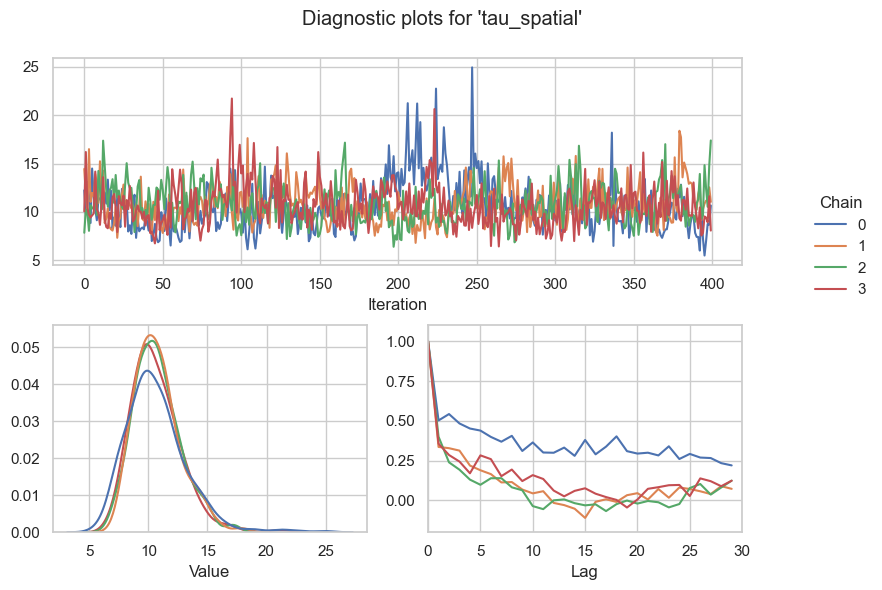

In [85]:
try:
    gs.plot_param(results4, "tau2_spatial")
except KeyError:
    gs.plot_param(results4, "tau_spatial")

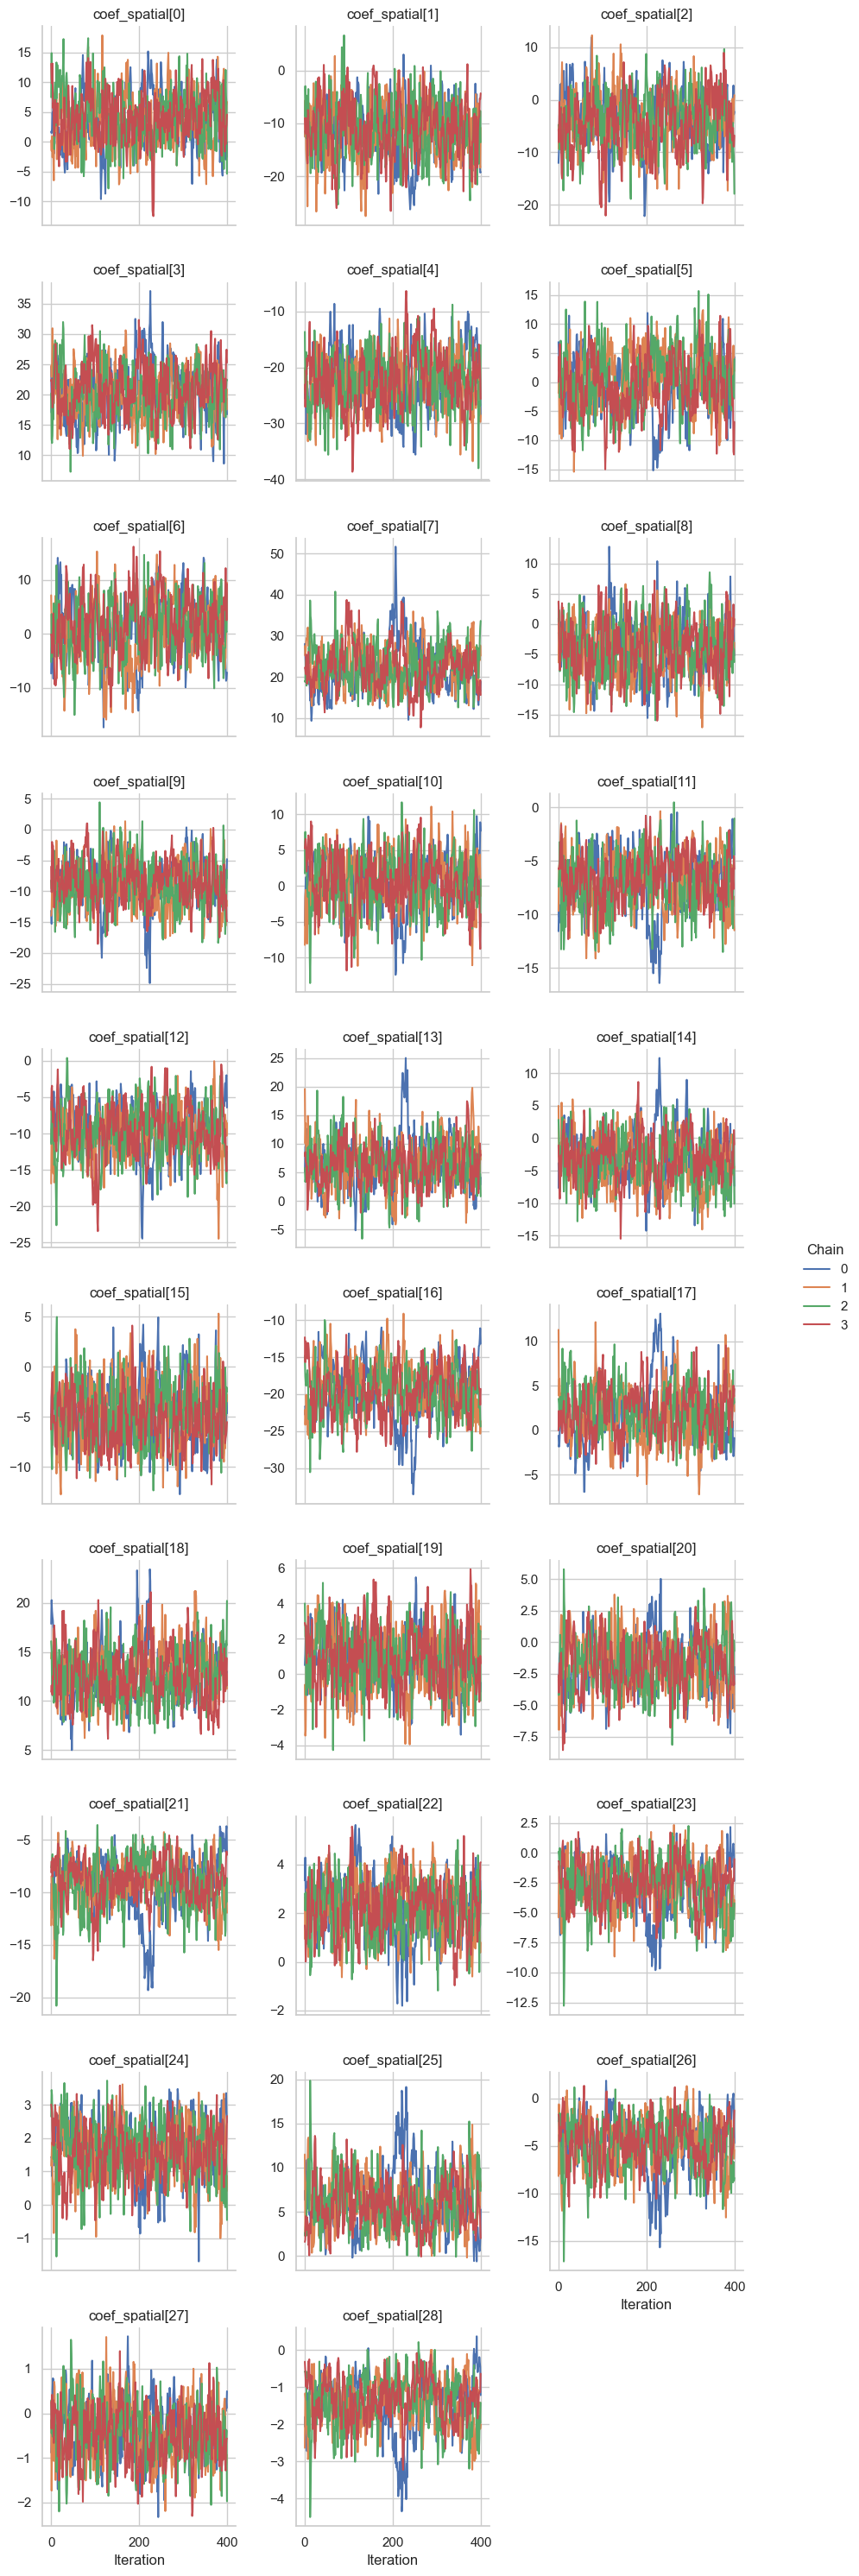

In [86]:
gs.plot_trace(results4, "coef_spatial")

In [87]:
s_spatial_samples = np.asarray(samples4[s_spatial.name])
s_spatial_mean = np.mean(s_spatial_samples, axis=(0, 1))

spatial_df = pd.DataFrame({
    "x": forest["x"].values,
    "y": forest["y"].values,
    "s_spatial_mean": s_spatial_mean,
})

spatial_df

x    y  s_spatial_mean
0      1.5  5.0       -3.380282
1      1.5  5.0       -3.380282
2      1.5  5.0       -3.380282
3      1.5  5.0       -3.380282
4      1.5  5.0       -3.380282
...    ...  ...             ...
1791  16.1  2.0       -0.602497
1792  16.1  2.0       -0.602497
1793  16.1  2.0       -0.602497
1794  16.1  2.0       -0.602497
1795  16.1  2.0       -0.602497

[1796 rows x 3 columns]

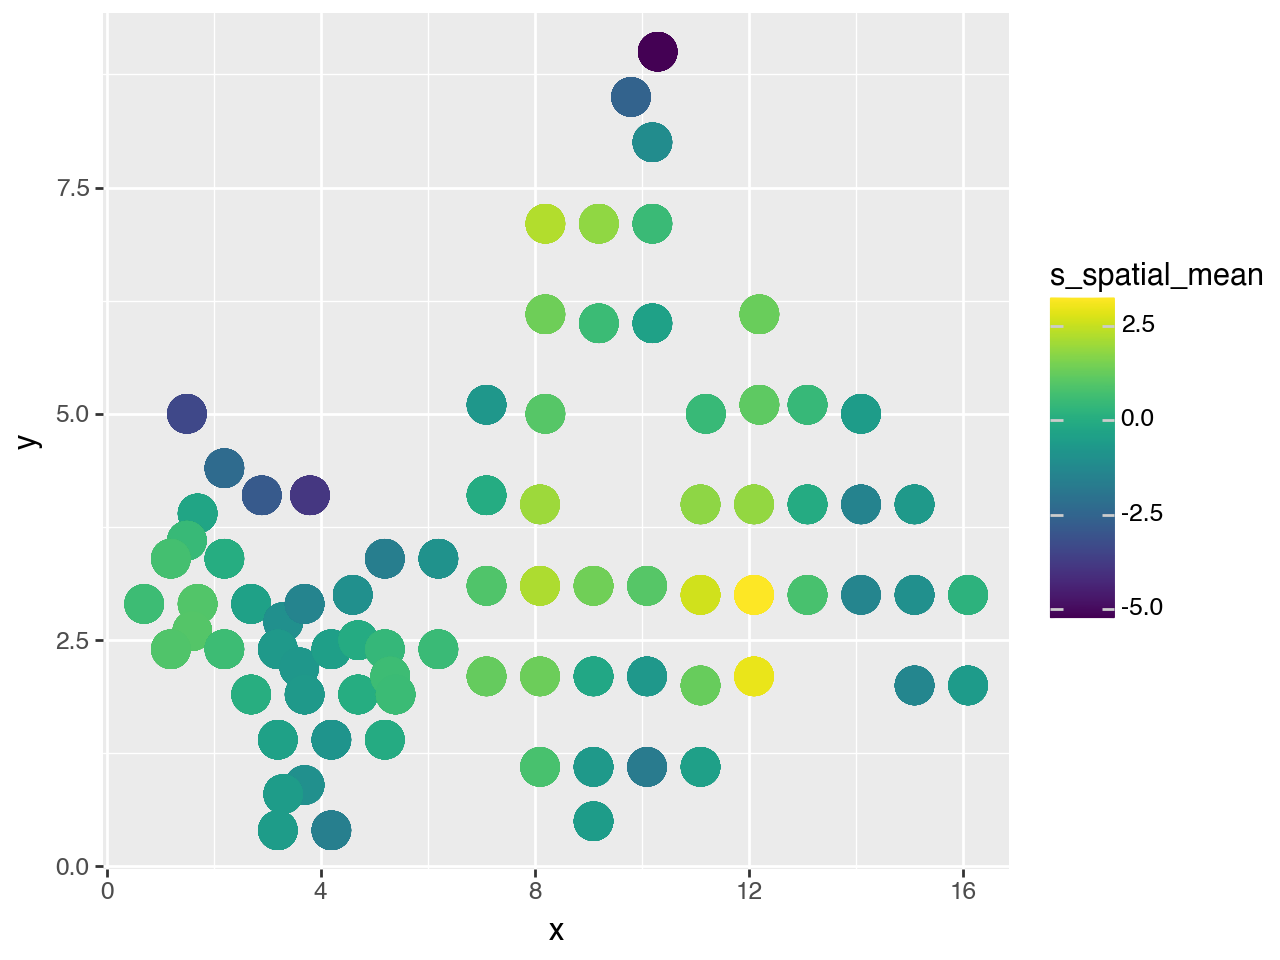

In [88]:
(
    p9.ggplot(spatial_df)
    + p9.geom_point(
        p9.aes(x="x", y="y", fill="s_spatial_mean", color="s_spatial_mean"), size=7
    )
)

# Liesel bonus exercises

## Use one joint sampler

In [106]:
eb = gs.EngineBuilder(seed=42, num_chains=4)

eb.set_model(interface)
eb.set_initial_values(preopt.model_state)


eb.add_kernel(gs.HMCKernel([
    intercept.name,
    coef_age.name,
    coef_canopy.name,
    coef_spatial.name,
    var_param_age.name,
    var_param_canopy.name,
    var_param_spatial.name
], da_target_accept=0.6))

eb.positions_included = [s_age.name, s_canopy.name, s_spatial.name]

eb.set_duration(warmup_duration=1000, posterior_duration=1000)

engine = eb.build()

liesel.goose.builder - WARNING - No jitter functions provided. The initial values won't be jittered
liesel.goose.engine - INFO - Initializing kernels...


liesel.goose.engine - INFO - Done


In [107]:
engine.sample_all_epochs()

liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 75 transitions, 25 jitted together
100%|██████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/chunk]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 21, 22, 25, 25 / 75 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 573.38chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 10, 9, 8, 8 / 25 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|█████████████████████████████████████████| 2/2 [00:00<00:00, 825.73chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 17, 16, 12, 16 / 50 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW

In [108]:
results4a = engine.get_results()
summary4a = gs.Summary(results4a, deselected=eb.positions_included)

In [109]:
summary4a

Parameter summary:

                       kernel       mean        sd     q_0.05      q_0.5  \
parameter    index                                                         
coef_age     (0,)   kernel_00   3.980540  1.171030   2.072002   4.458580   
             (1,)   kernel_00   2.251620  1.465566  -0.061424   2.135705   
             (2,)   kernel_00   1.110851  1.132033  -0.759242   1.112684   
             (3,)   kernel_00  -0.881292  1.361922  -3.180181  -0.836470   
             (4,)   kernel_00   0.565568  0.910796  -0.903988   0.537393   
             (5,)   kernel_00   2.384378  1.176762   0.489833   2.355869   
             (6,)   kernel_00   0.033952  0.451076  -0.645538  -0.031572   
             (7,)   kernel_00  -1.225227  0.366805  -1.810548  -1.210103   
             (8,)   kernel_00   3.403557  3.768292  -1.906207   2.778999   
coef_canopy  (0,)   kernel_00   0.076714  0.503138  -0.710230   0.074296   
             (1,)   kernel_00  -0.100939  0.532577  -1.011738  -0.050369   
             (2,)   kernel_00  -0.203747  0.525056  -1.151742  -0.154452   
             (3,)   kernel_00  -0.027533  0.506256  -0.801711  -0.024412   
             (4,)   kernel_00   0.110527  0.397919  -0.493673   0.080207   
             (5,)   kernel_00  -0.161519  0.398406  -0.959709  -0.115531   
             (6,)   kernel_00   0.634612  0.200275   0.335962   0.614286   
             (7,)   kernel_00   0.221641  0.130074   0.040472   0.203547   
             (8,)   kernel_00   0.322683  1.984796  -1.841994  -0.069051   
coef_spatial (0,)   kernel_00   2.354521  3.926864  -4.716216   2.417266   
             (1,)   kernel_00  -9.473999  3.820829 -16.123071  -9.002503   
             (2,)   kernel_00  -4.893746  5.233331 -14.384373  -3.843377   
             (3,)   kernel_00  21.148781  4.175215  14.857179  20.303877   
             (4,)   kernel_00 -21.818850  4.717978 -30.046230 -21.567078   
             (5,)   kernel_00  -0.487492  5.270247  -8.960845  -0.452829   
             (6,)   kernel_00   1.132062  4.733792  -6.579073   1.326563   
             (7,)   kernel_00  22.188667  5.185108  13.993170  22.069000   
             (8,)   kernel_00  -2.674081  4.209656  -9.639138  -2.751361   
             (9,)   kernel_00  -9.623724  3.817815 -16.257563  -9.319859   
             (10,)  kernel_00   0.615048  3.465593  -5.301360   0.678551   
             (11,)  kernel_00  -6.593953  2.165800 -10.230778  -6.596677   
             (12,)  kernel_00  -9.732720  3.423386 -15.396151  -9.762355   
             (13,)  kernel_00   6.147669  3.504930   0.513539   6.232839   
             (14,)  kernel_00  -3.225814  3.569980  -9.036519  -3.143707   
             (15,)  kernel_00  -4.944169  2.858509  -9.538147  -4.969009   
             (16,)  kernel_00 -17.925280  2.940196 -22.821577 -17.826752   
             (17,)  kernel_00   1.880154  2.692207  -2.432138   1.766444   
             (18,)  kernel_00  13.027663  2.689163   8.729096  12.957133   
             (19,)  kernel_00   0.586083  1.468825  -1.848578   0.580362   
             (20,)  kernel_00  -1.630592  1.755087  -4.398267  -1.711473   
             (21,)  kernel_00  -8.779872  2.043678 -12.493957  -8.670782   
             (22,)  kernel_00   2.428385  1.107212   0.598298   2.422722   
             (23,)  kernel_00  -2.768103  1.526719  -5.528578  -2.626322   
             (24,)  kernel_00   1.796037  0.724118   0.531562   1.833044   
             (25,)  kernel_00   5.087751  2.150614   1.376634   5.067635   
             (26,)  kernel_00  -4.148705  2.049257  -7.582575  -4.111906   
             (27,)  kernel_00  -0.419362  0.575332  -1.393449  -0.369666   
             (28,)  kernel_00  -1.283178  0.485080  -2.129537  -1.261608   
intercept    ()     kernel_00  -0.984935  0.102136  -1.161606  -0.978148   
tau_age      ()     kernel_00   2.708830  1.510025   1.221878   2.339057   
tau_canopy   ()     kernel_00   0.513281  0.279213   0.209822   0.445088   
tau_spatial  ()     kernel_0

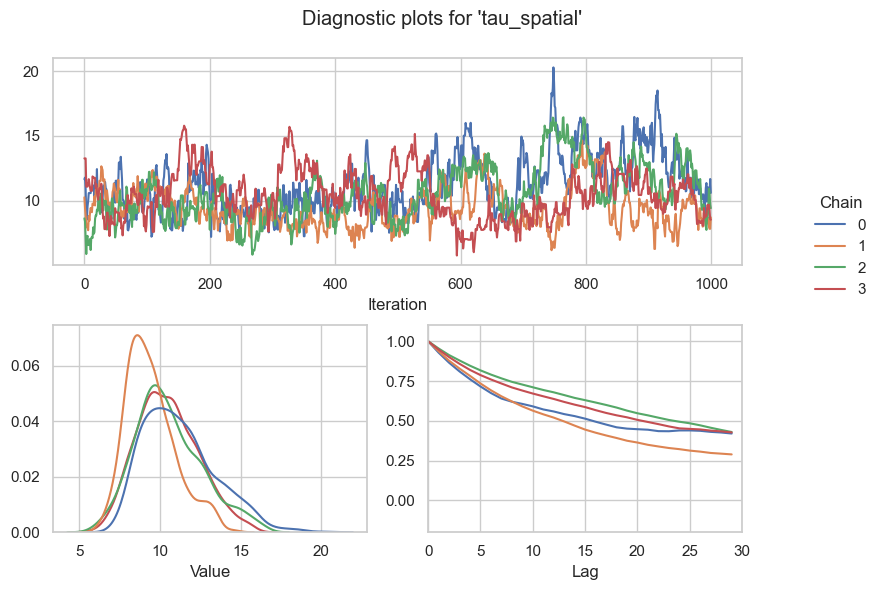

In [110]:
try:
    gs.plot_param(results4a, "tau2_spatial")
except KeyError:
    gs.plot_param(results4a, "tau_spatial")

## Use Inverse Gamma priors and Gibbs sampler

In [111]:
_ = model4.pop_nodes_and_vars()

### Swap out prior

In [112]:
# set up new variable
tau2_spatial_ig = lsl.Dist(
    tfd.InverseGamma,
    concentration=lsl.Var.new_param(0.01, name="a_spatial"),
    scale=lsl.Var.new_param(0.01, name="b_spatial")
)

tau2_spatial = lsl.Var.new_param(10.0, tau2_spatial_ig, name="tau2_spatial")

# swap out old variable for new one
coef_spatial.dist_node["var"] = tau2_spatial

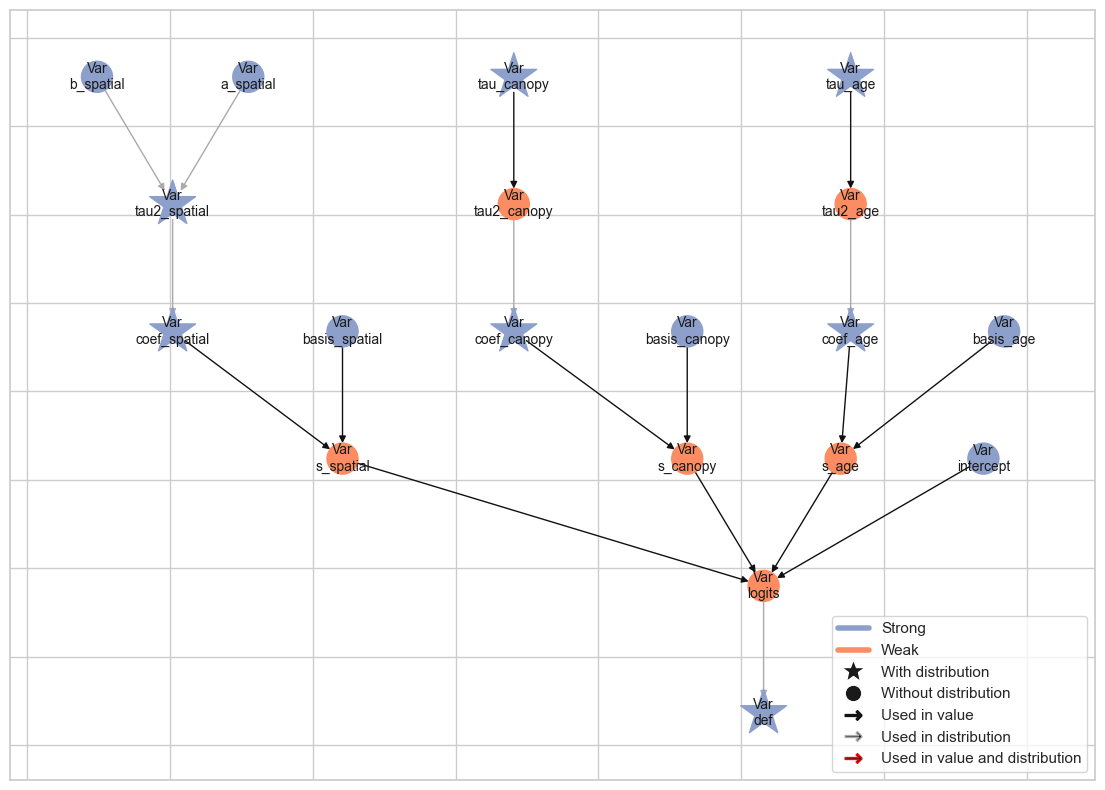

In [113]:
def_.plot_vars()

In [114]:
model4b = lsl.Model([def_])

In [145]:
# crude, but robust optimization
preopt = gs.optim_flat(
    model_train=model4b,
    params=[intercept.name, coef_age.name, coef_canopy.name, coef_spatial.name],
    stopper=gs.Stopper(max_iter=10_000, patience=10, atol=1e-3),
    optimizer=optax.adam(learning_rate=0.01)
)

Training loss: 930.354, Validation loss: 930.354:  26%|██▌       | 2554/10000 [00:16<00:45, 162.98it/s] 

### Set up Gibbs Kernel

In [146]:
import jax

def inverse_smoothing_param_gibbs_kernel(
    name: str,
    interface: gs.LieselInterface,
    a: str,
    b: str,
    penalty: str,
    rank: str,
    coef: str,
) -> gs.GibbsKernel:
    """Builds a Gibbs kernel for a smoothing parameter with an inverse gamma prior."""

    def transition(prng_key, model_state):
        pos = interface.extract_position([a, b, penalty, rank, coef], model_state)
        a_value = pos[a]
        b_value = pos[b]

        rank_value = pos[rank]
        K = pos[penalty]

        beta = pos[coef]

        a_gibbs = jnp.squeeze(a_value + 0.5 * rank_value)
        b_gibbs = jnp.squeeze(b_value + 0.5 * (beta @ K @ beta))

        draw = b_gibbs / jax.random.gamma(prng_key, a_gibbs)

        return {name: draw}

    return gs.GibbsKernel([name], transition)

In [147]:
interface = gs.LieselInterface(model4b)

eb = gs.EngineBuilder(seed=42, num_chains=4)

eb.set_model(interface)
eb.set_initial_values(preopt.model_state)

eb.add_kernel(gs.NUTSKernel([intercept.name]))

eb.add_kernel(gs.IWLSKernel([coef_age.name]))
eb.add_kernel(gs.IWLSKernel([coef_canopy.name]))
eb.add_kernel(gs.IWLSKernel([coef_spatial.name]))

eb.add_kernel(gs.NUTSKernel([var_param_age.name]))
eb.add_kernel(gs.NUTSKernel([var_param_canopy.name]))


tau2_gibbs_kernel = inverse_smoothing_param_gibbs_kernel(
    name=tau2_spatial.name,
    interface=interface,
    
    a=tau2_spatial.dist_node["concentration"].name,
    b=tau2_spatial.dist_node["scale"].name,

    rank=coef_spatial.dist_node["rank"].name,
    penalty=coef_spatial.dist_node["pen"].name,
    coef=coef_spatial.name
)

eb.add_kernel(tau2_gibbs_kernel)

eb.positions_included = [s_age.name, s_canopy.name, s_spatial.name]

eb.set_duration(warmup_duration=2000, posterior_duration=4000, thinning_posterior=10)

engine = eb.build()

liesel.goose.builder - WARNING - No jitter functions provided. The initial values won't be jittered
liesel.goose.engine - INFO - Initializing kernels...


liesel.goose.engine - INFO - Done


In [148]:
engine.sample_all_epochs()

liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 75 transitions, 25 jitted together
100%|██████████████████████████████████████████| 3/3 [00:10<00:00,  3.51s/chunk]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 1, 3, 1, 1 / 75 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_04: 6, 9, 4, 7 / 75 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_05: 7, 9, 8, 9 / 75 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 524.09chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 1, 1, 1, 2 / 25 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_04: 4, 3, 4, 3 / 25 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_05: 3, 3, 4, 3 / 25 transitions
liesel.goose.engine - INFO - Finished epoch
lies

In [150]:
results4b = engine.get_results()

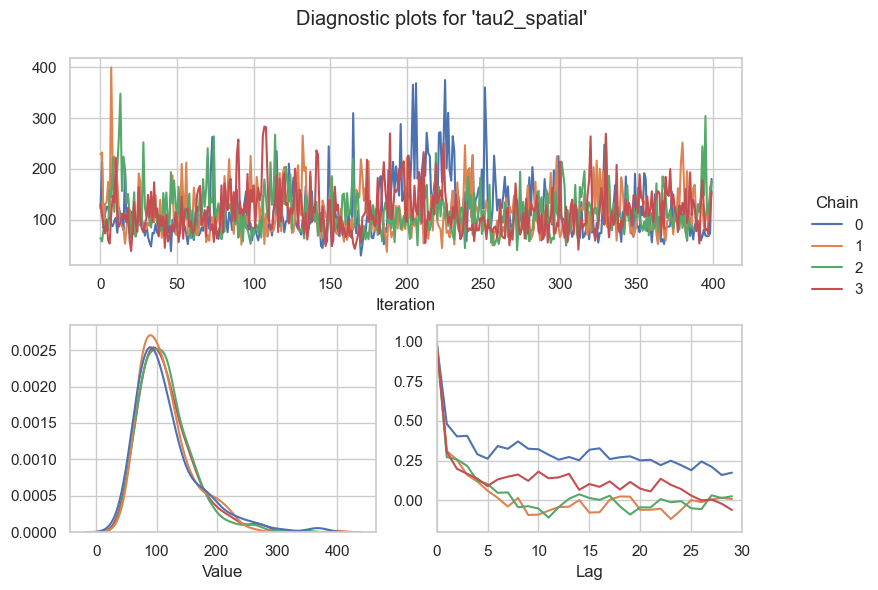

In [152]:
try:
    gs.plot_param(results4b, "tau2_spatial")
except KeyError:
    gs.plot_param(results4b, "tau_spatial")

## Transform parameter to real line

In [153]:
_ = model4b.pop_nodes_and_vars()

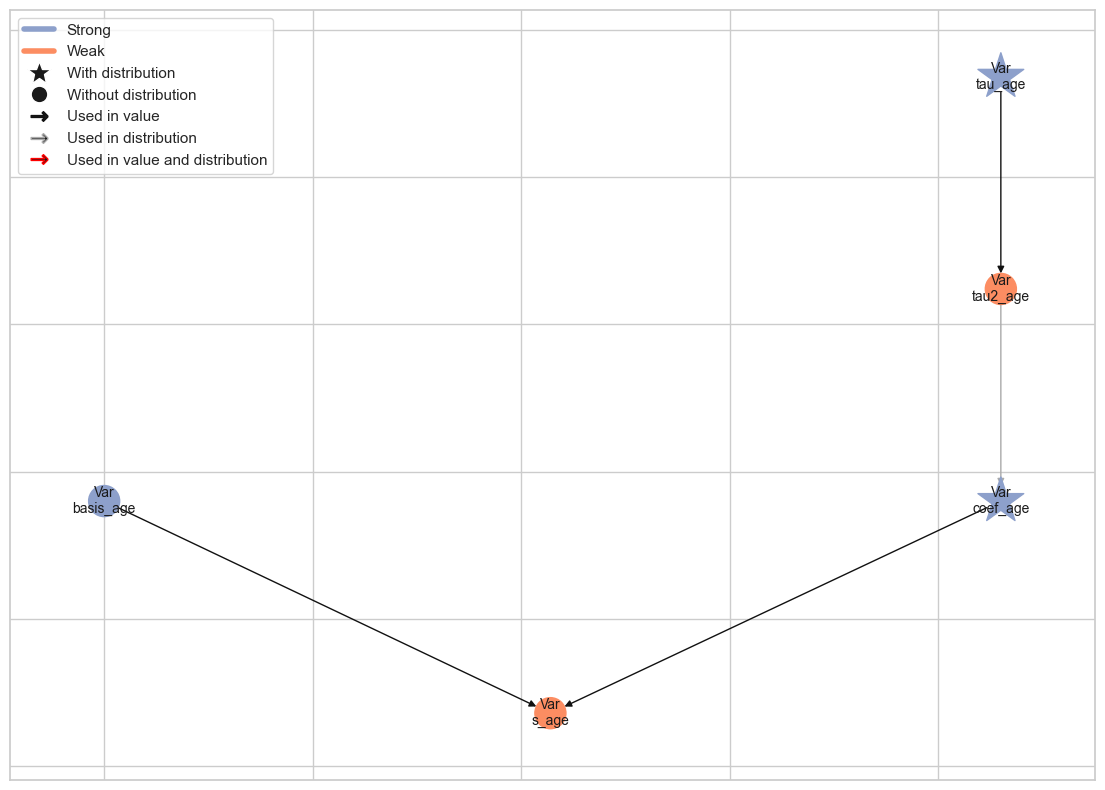

In [155]:
s_age.plot_vars()

In [156]:
import tensorflow_probability.substrates.jax.bijectors as tfb
tau_age_transformed = tau_age.transform(tfb.Exp())

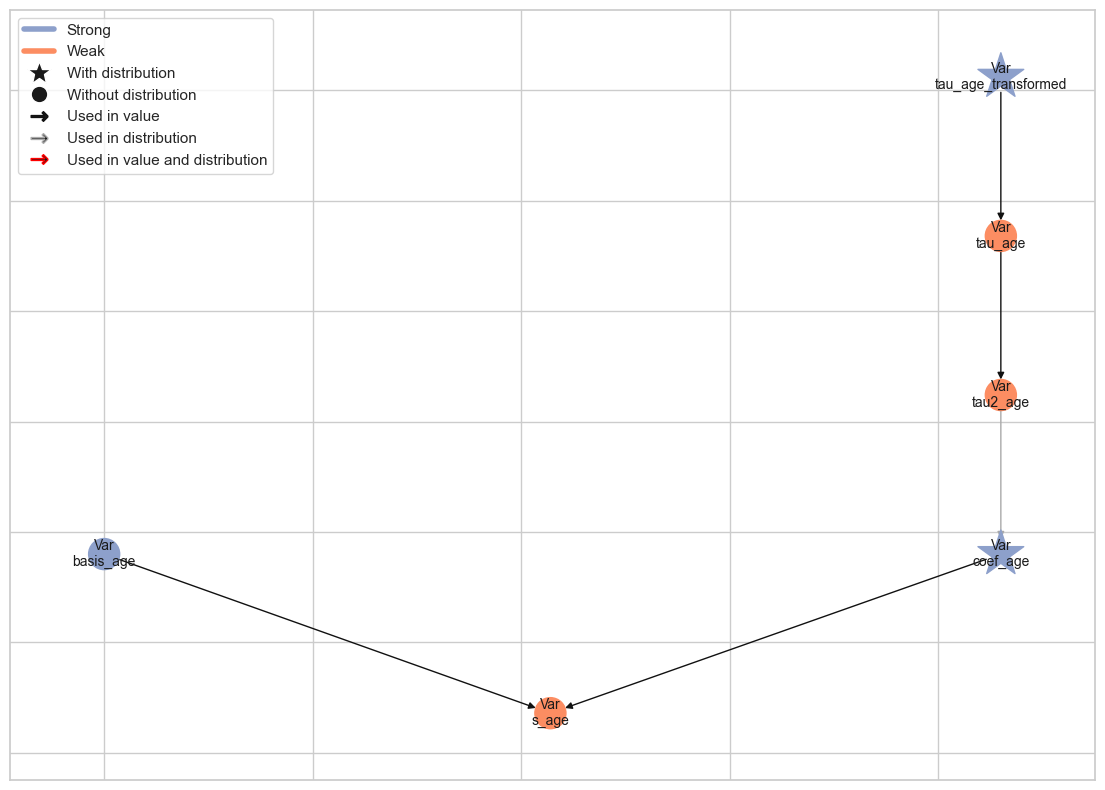

In [157]:
s_age.plot_vars()

In [158]:
model4c = lsl.Model([def_])

In [159]:
# crude, but robust optimization
preopt = gs.optim_flat(
    model_train=model4c,
    params=[intercept.name, coef_age.name, coef_canopy.name, coef_spatial.name],
    stopper=gs.Stopper(max_iter=10_000, patience=10, atol=1e-3),
    optimizer=optax.adam(learning_rate=0.01)
)

Training loss: 928.053, Validation loss: 928.053:  25%|██▌       | 2539/10000 [00:17<00:49, 152.04it/s] 

In [168]:
interface = gs.LieselInterface(model4c)

eb = gs.EngineBuilder(seed=42, num_chains=4)

eb.set_model(interface)
eb.set_initial_values(preopt.model_state)

eb.add_kernel(gs.NUTSKernel([intercept.name]))

eb.add_kernel(gs.IWLSKernel([coef_age.name]))
eb.add_kernel(gs.IWLSKernel([coef_canopy.name]))
eb.add_kernel(gs.IWLSKernel([coef_spatial.name]))

eb.add_kernel(gs.HMCKernel([tau_age_transformed.name], da_target_accept=0.6))

eb.add_kernel(gs.NUTSKernel([var_param_canopy.name]))


tau2_gibbs_kernel = inverse_smoothing_param_gibbs_kernel(
    name=tau2_spatial.name,
    interface=interface,
    
    a=tau2_spatial.dist_node["concentration"].name,
    b=tau2_spatial.dist_node["scale"].name,

    rank=coef_spatial.dist_node["rank"].name,
    penalty=coef_spatial.dist_node["pen"].name,
    coef=coef_spatial.name
)

eb.add_kernel(tau2_gibbs_kernel)

eb.positions_included = [s_age.name, s_canopy.name, s_spatial.name, tau_age.name]

eb.set_duration(warmup_duration=2000, posterior_duration=4000, thinning_posterior=10)

engine = eb.build()

liesel.goose.builder - WARNING - No jitter functions provided. The initial values won't be jittered
liesel.goose.engine - INFO - Initializing kernels...


liesel.goose.engine - INFO - Done


In [169]:
engine.sample_all_epochs()

liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 75 transitions, 25 jitted together


100%|██████████████████████████████████████████| 3/3 [00:07<00:00,  2.41s/chunk]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 1, 2, 2, 0 / 75 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_04: 24, 25, 22, 25 / 75 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_05: 11, 9, 5, 9 / 75 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 475.98chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 1, 1, 1, 1 / 25 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_04: 8, 8, 7, 9 / 25 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_05: 2, 3, 4, 5 / 25 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together

In [170]:
results4c = engine.get_results()

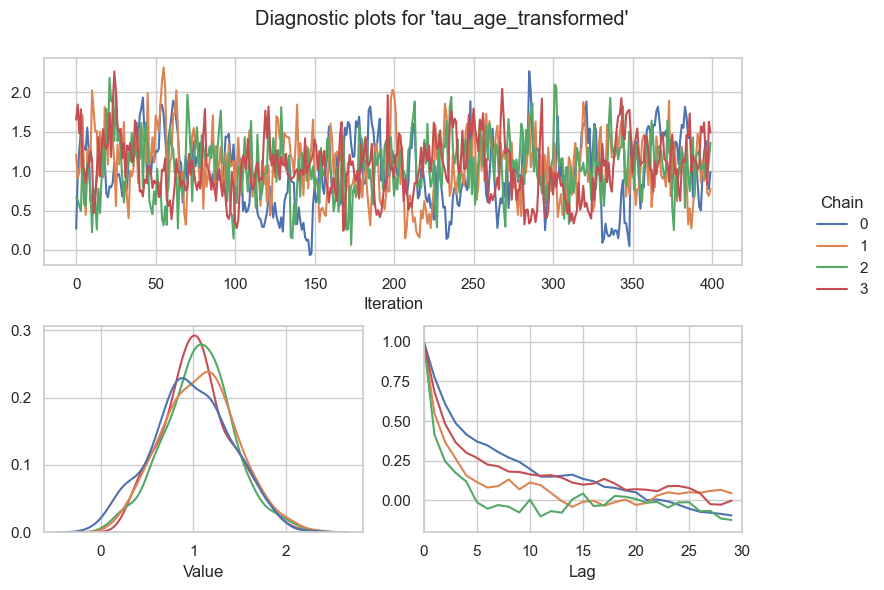

In [171]:
gs.plot_param(results4c, tau_age_transformed.name)

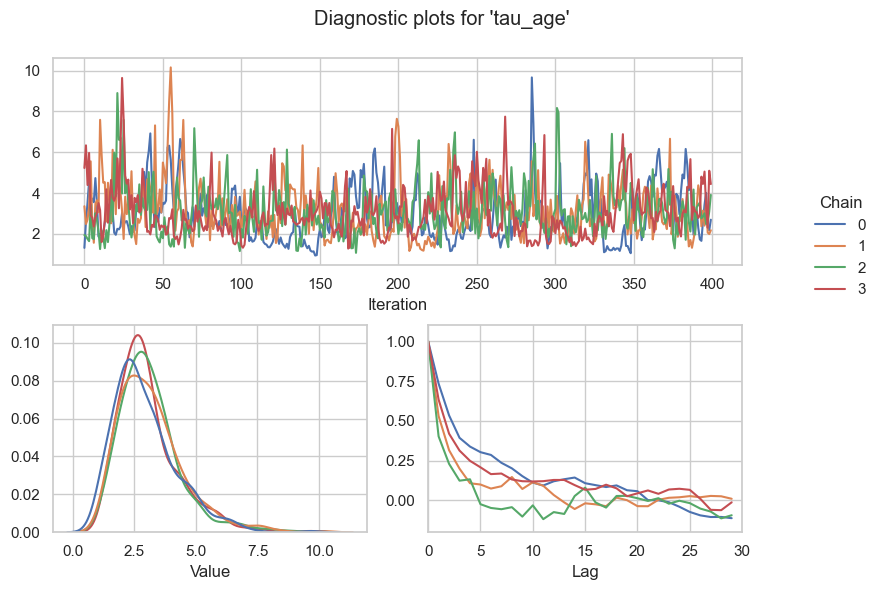

In [172]:
gs.plot_param(results4c, tau_age.name)